# **Feature Engineering**

## Objectives

* Engineer features for Regression model.

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* Generate a list with variables to engineer.

## Conclusions

* We are going to apply 4 different transformation [more info](#conclusions-and-next-steps)


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Prediction-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Prediction-heritage-housing'

---

# Load Cleaned Data

## Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828       0.0           3.0           Av          48      Missing   
1       894       0.0           2.0           No           0          Unf   
2       964       0.0           2.0           No         713          ALQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0       1774         774          Unf       2007.0  ...    11694        90.0   
1        894         308      Missing       1962.0  ...     6600        60.0   
2        163         432          Unf       1921.0  ...    13360        80.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0          108            5            9         1822       2007   
1         0.0            0            5            5          894       1962   
2         0.0            0            7            5          876       1921   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  

[3 rows x 22 columns]

## Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      2515       0.0           4.0           No        1219          Rec   
1       958     620.0           3.0           No         403          BLQ   
2       979     224.0           3.0           No         185          LwQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0        816         484      Missing       1975.0  ...    32668        69.0   
1        238         240          Unf       1941.0  ...     9490        79.0   
2        524         352          Unf       1950.0  ...     7015        69.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0            0            3            6         2035       1957   
1         0.0            0            7            6          806       1941   
2       161.0            0            4            5          709       1950   

   YearRemodAdd  SalePrice  
0          1975     200624  
1          1950     133000  
2          1950     110000  

[3 rows x 22 columns]

---

# Data Exploration

We are evaluating the potential transformations we could do in the variables by using Pandas profiling report:

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

We can confirm again that we have in total 22 variables that include:
- 18 numericals: '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd' and 'SalePrice' (target variable).
- 4 categoricals: 'BsmtExposure', 'BsmtFinType1', 'GarageFinish' and 'KitchenQual'.

---

# Feature Engineering

The following custom function is taken from the feature-engine lesson and helps with the feature engineering process. We can see that the function allow us to handle both numerical and categorical variables to find the best transformation and evaluate them. It will also plot the different results.

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

# Dealing with Feature Engineering

## Categorical Encoding 

1. First, we replace categories with ordinal numbers.

In [8]:
variables_engineering= ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
variables_engineering

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

2. Second, we create a separate DataFrame with the variables:

In [9]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           Av      Missing          Unf          Gd
1           No          Unf      Missing          TA
2           No          ALQ          Unf          TA

3. Then, we create engineered variables to assess engineered variables distribution by using **Ordinal encoding** to transform categorical features into a numerical format:

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



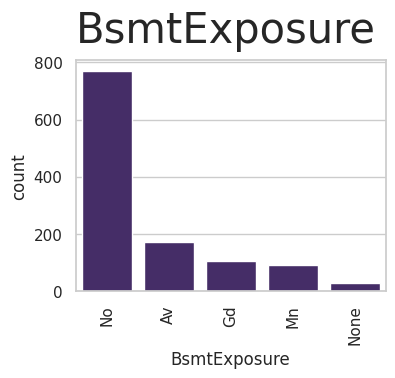

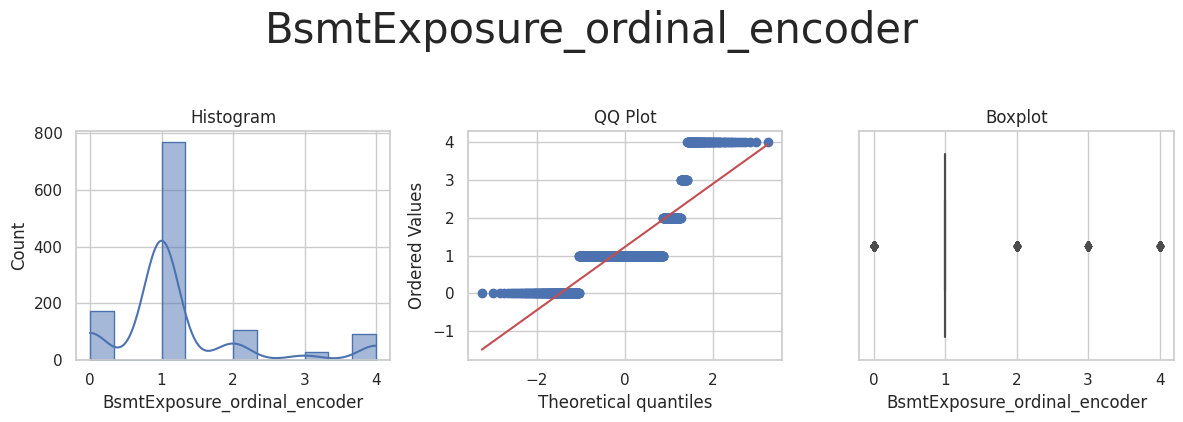



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



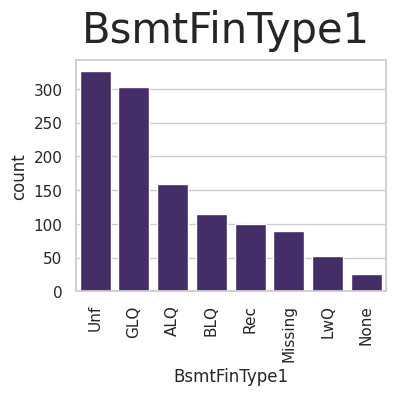

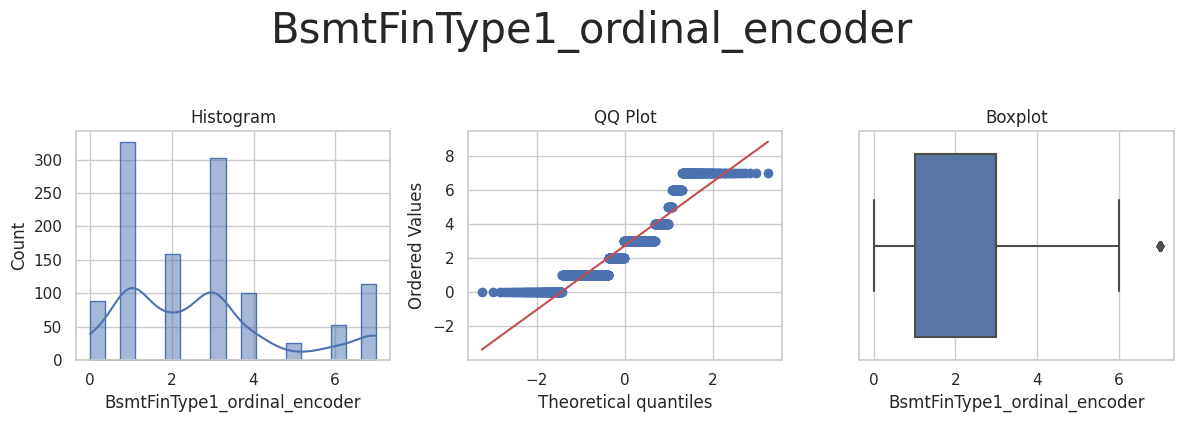



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



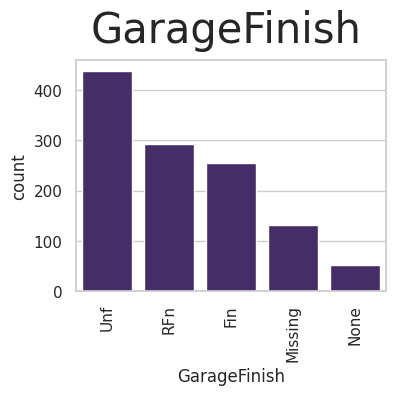

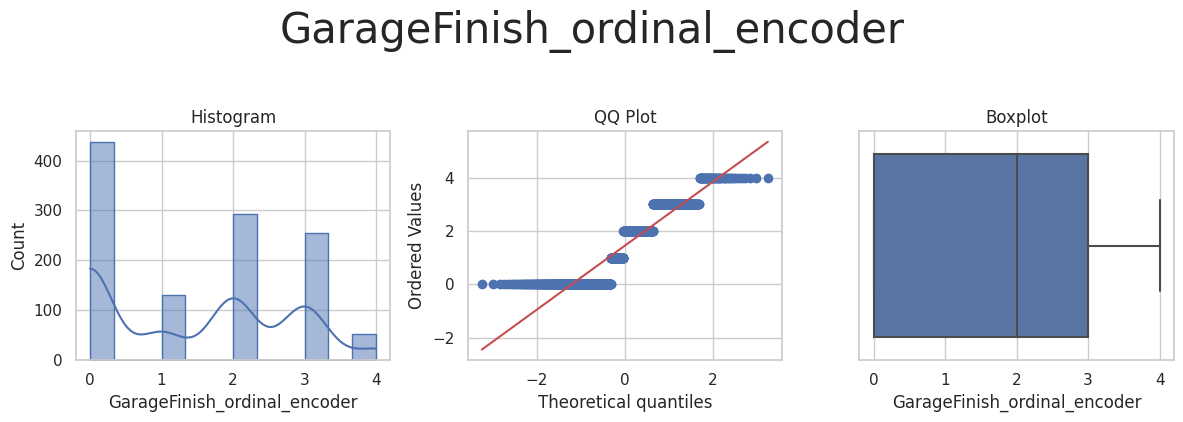



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



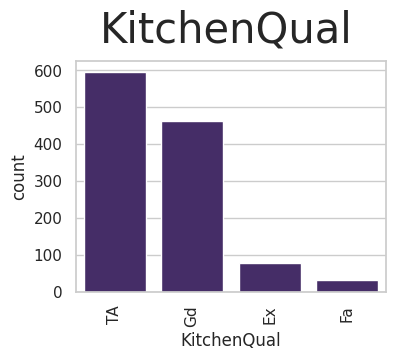

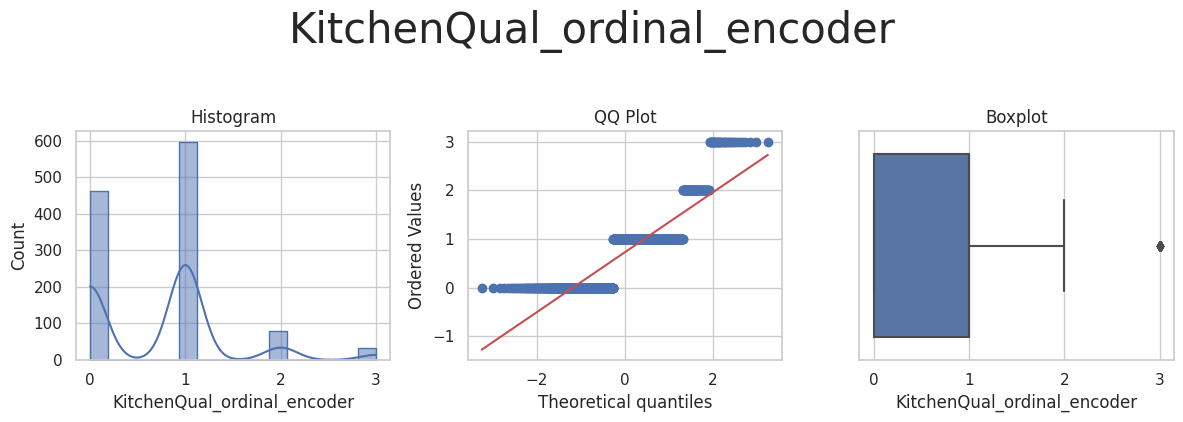

In [10]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

Interpretation:
* The Ordinal Encoder has been effective as all selected variables have been successfuly transform in numerical variables.
* The Histogram have different distributions depending on the value.
* The Quantile-Quantile (q-q) Plots have Staircase patterns means that the values are discretes.
* The Boxplots show that there is a small amount of outliers.

4. Finally, we apply `OrdinalEncoder` to the Train and Test set:

In [11]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


## Numerical Transformation

The steps will be similar as seen previously.

1. First, we select the variables:

In [12]:
variables_engineering = ['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF']
variables_engineering   

['1stFlrSF',
 '2ndFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF']

2. Second, we create a separate DataFrame, with the variables:

In [13]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  TotalBsmtSF  GarageArea  GarageYrBlt  GrLivArea  \
0      1828       0.0         1822         774       2007.0       1828   
1       894       0.0          894         308       1962.0        894   
2       964       0.0          876         432       1921.0        964   

   LotArea  LotFrontage  MasVnrArea  OpenPorchSF  
0    11694         90.0       452.0          108  
1     6600         60.0         0.0            0  
2    13360         80.0         0.0            0

3. Then, we create engineered variables to assess engineered variables distribution by using **Numerical Transformation Methods**:

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



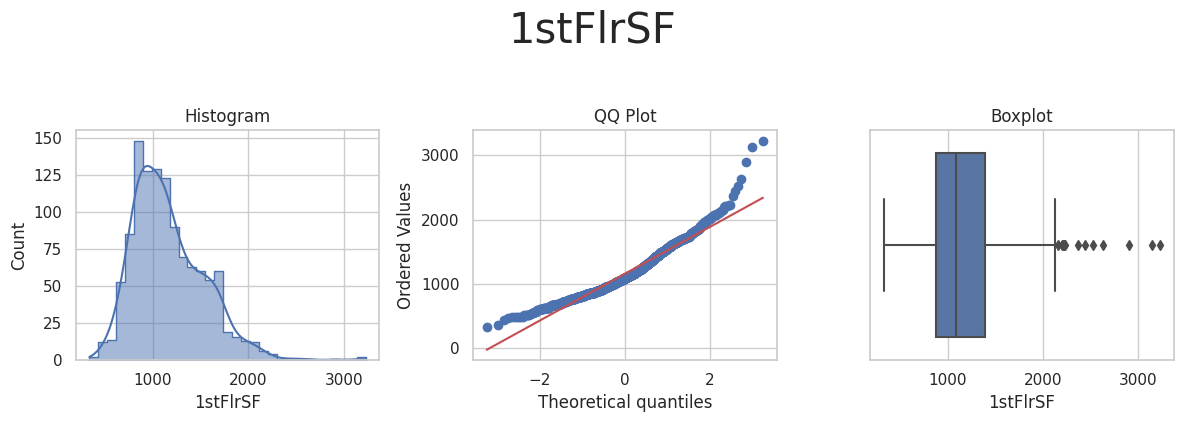

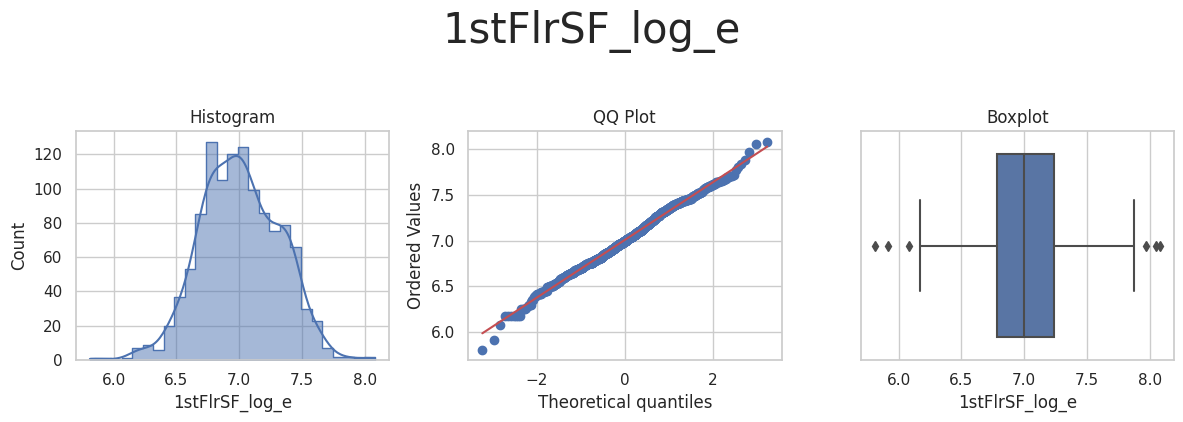

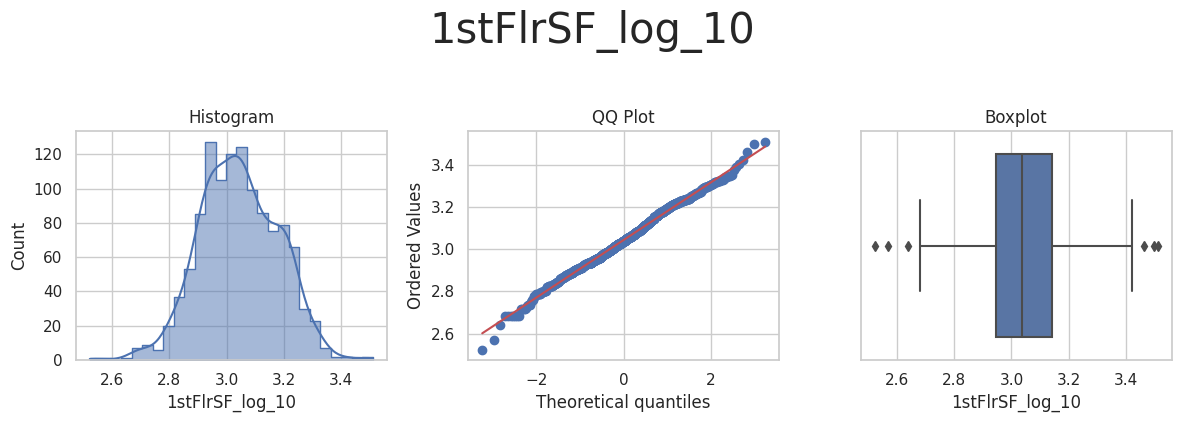

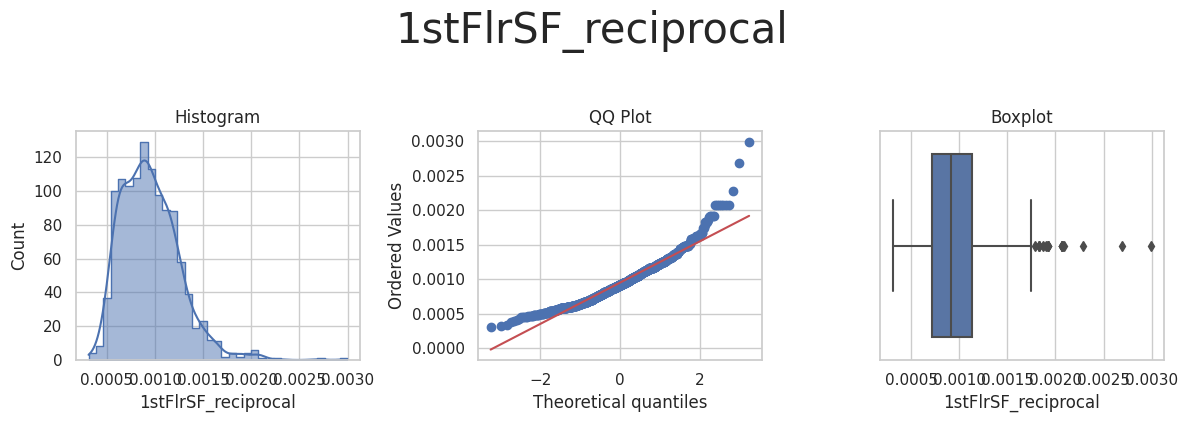

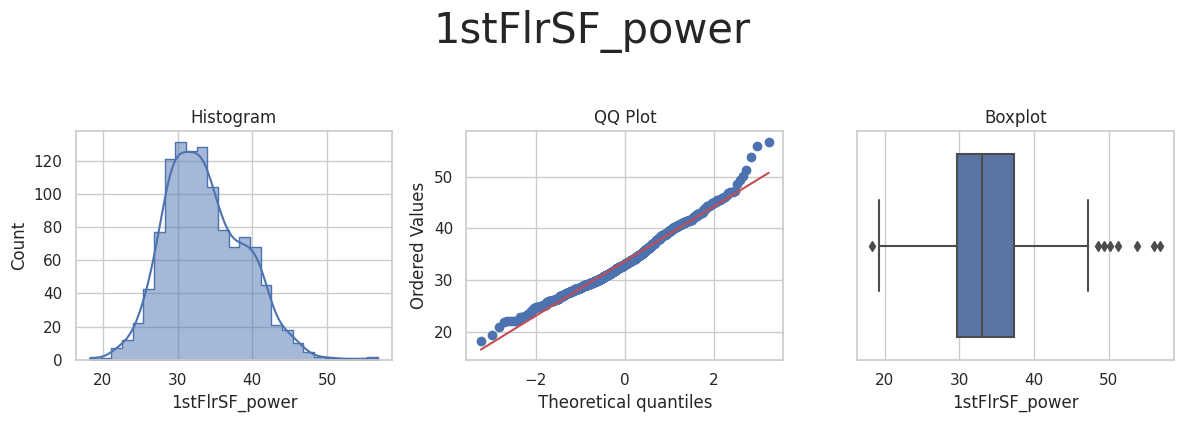

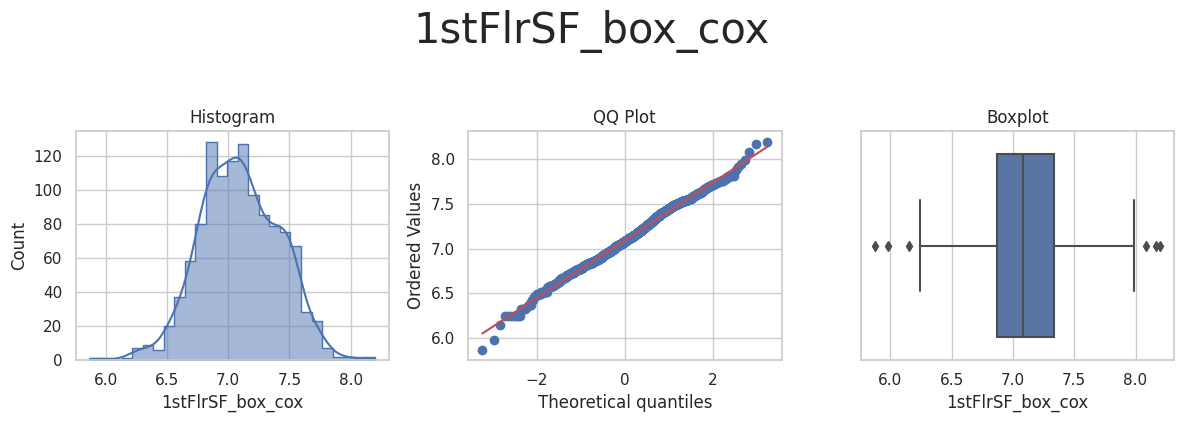

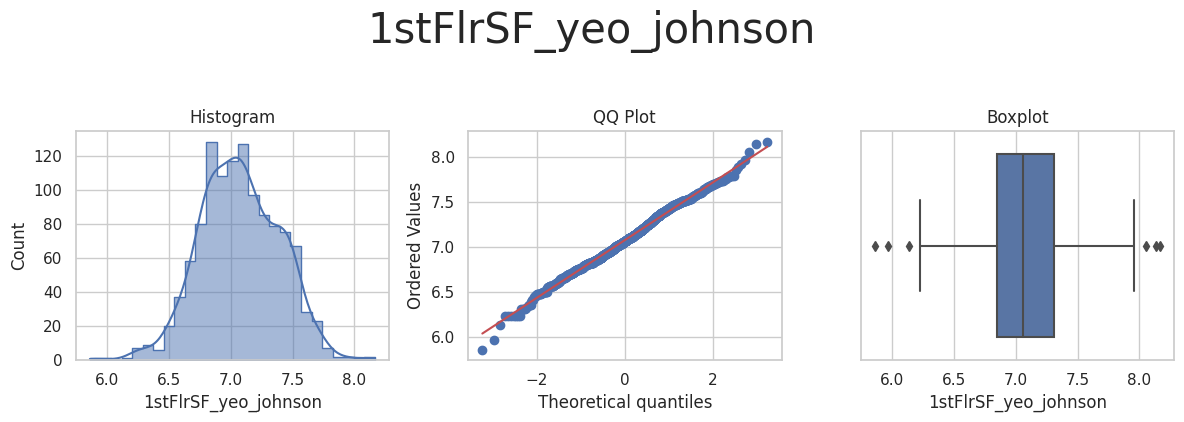



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



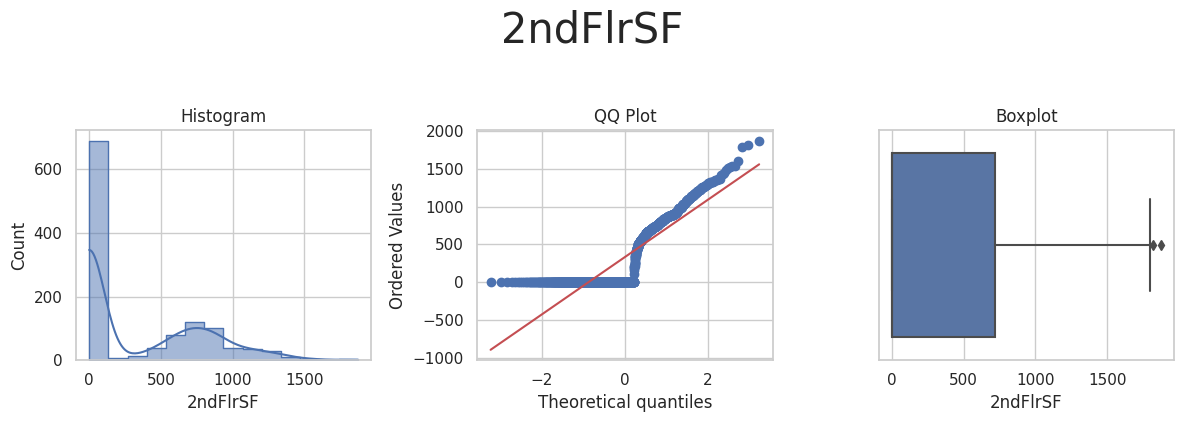

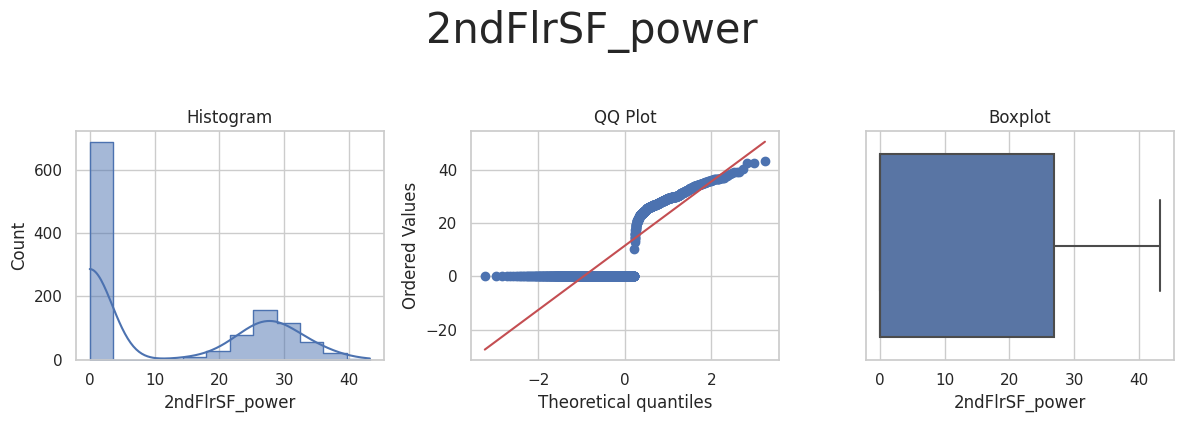

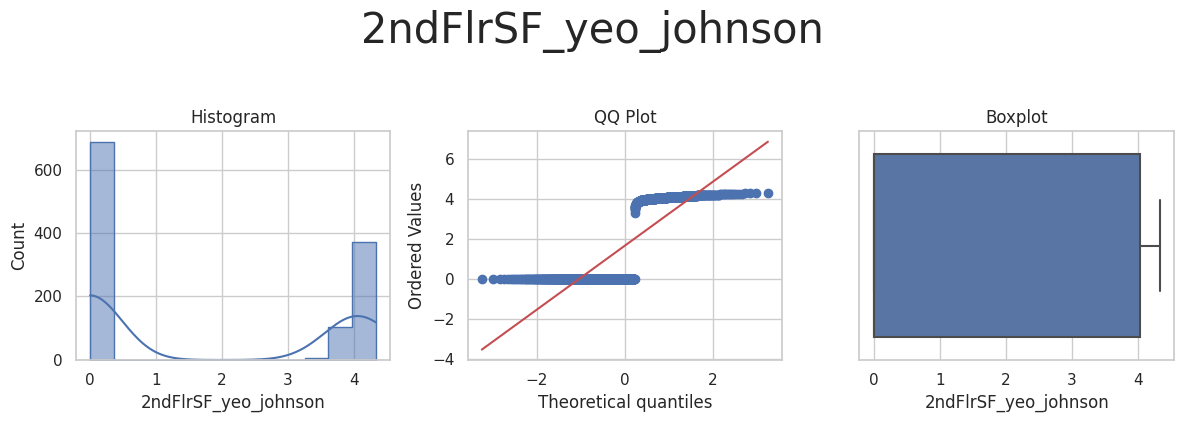



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



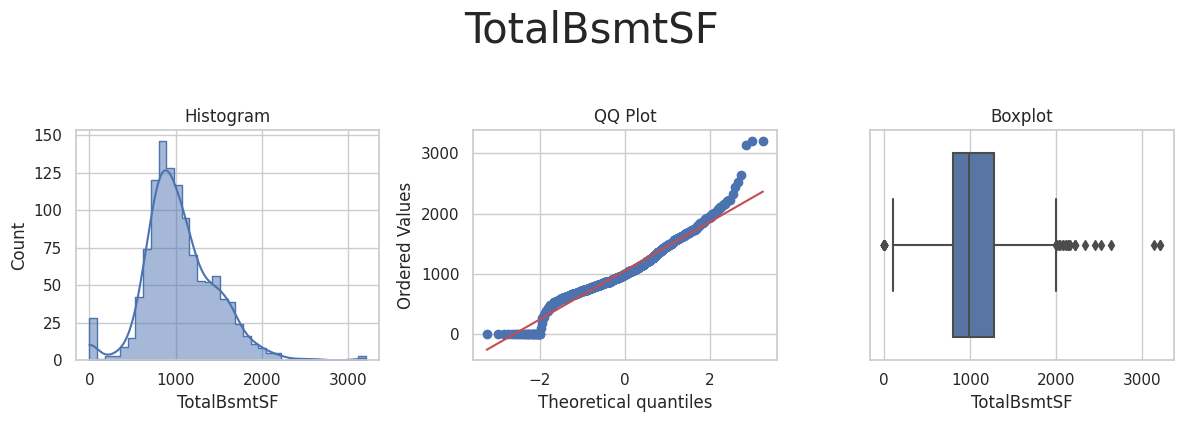

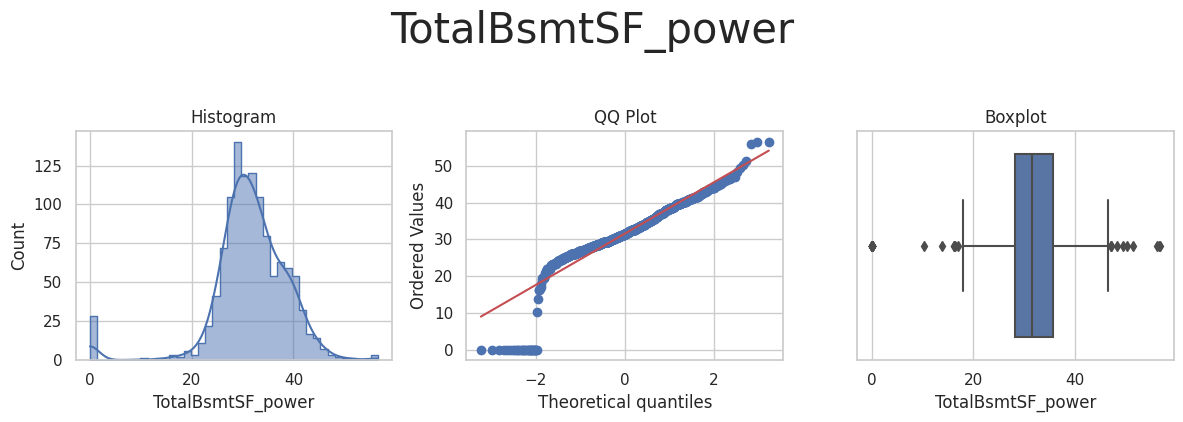

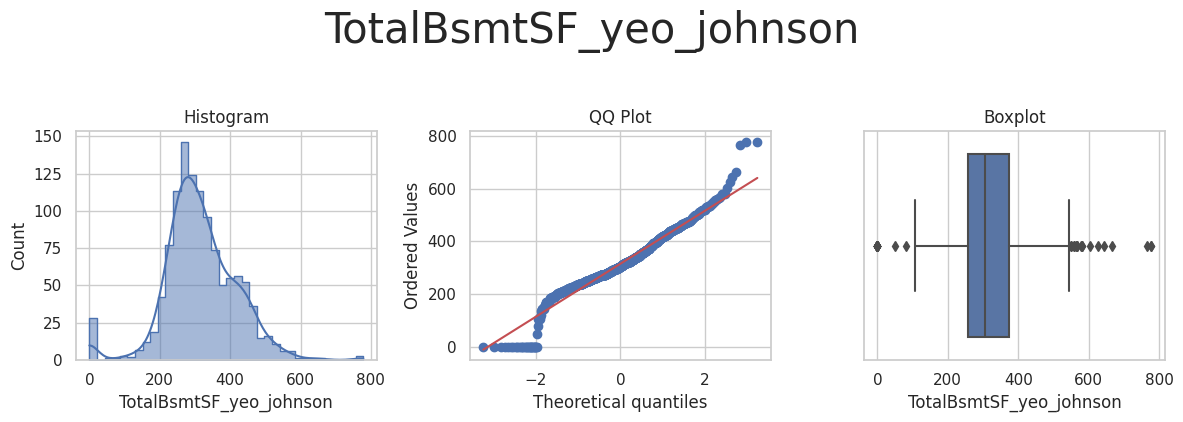



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



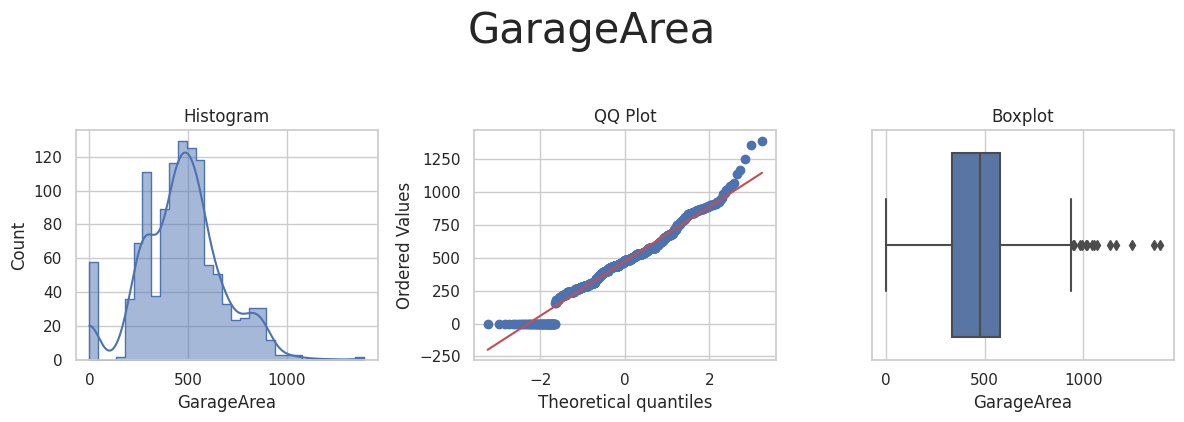

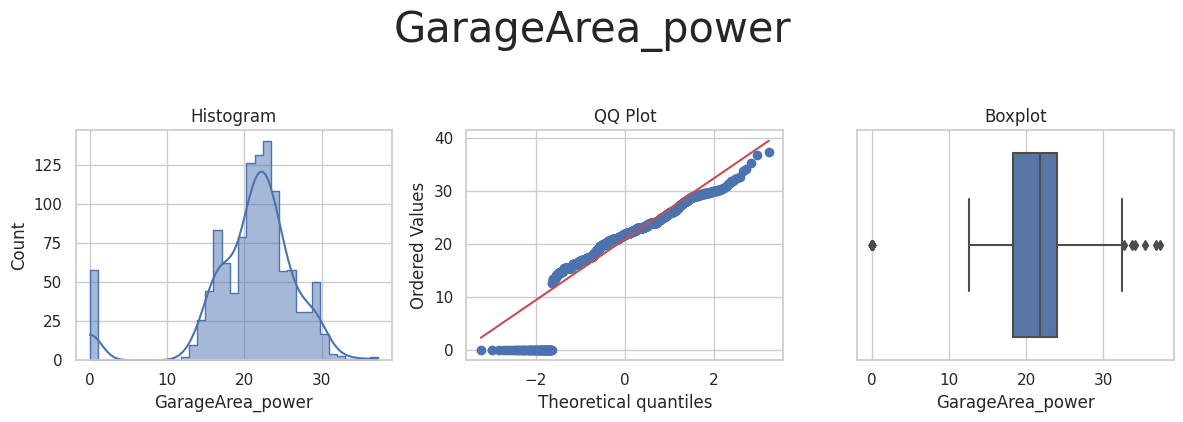

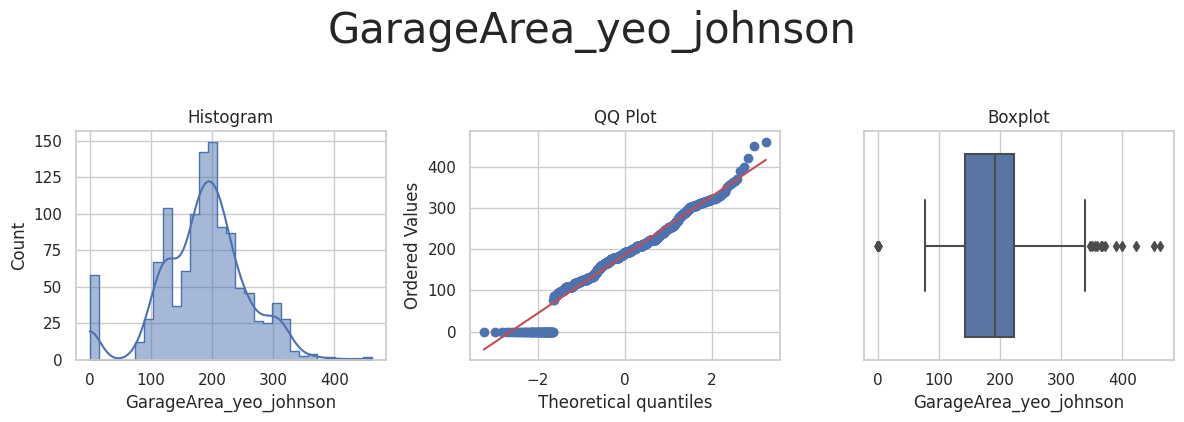



* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_log_e', 'GarageYrBlt_log_10', 'GarageYrBlt_reciprocal', 'GarageYrBlt_power', 'GarageYrBlt_box_cox', 'GarageYrBlt_yeo_johnson'] 



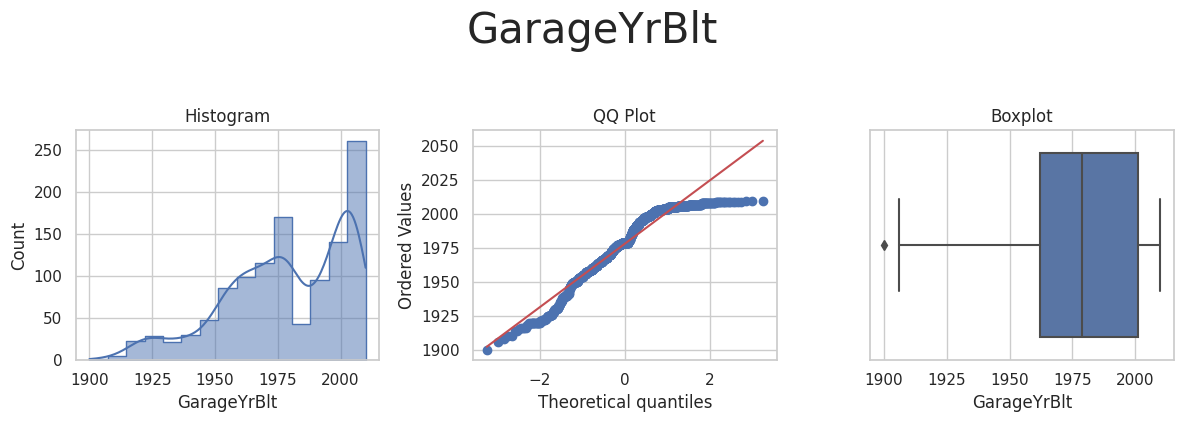

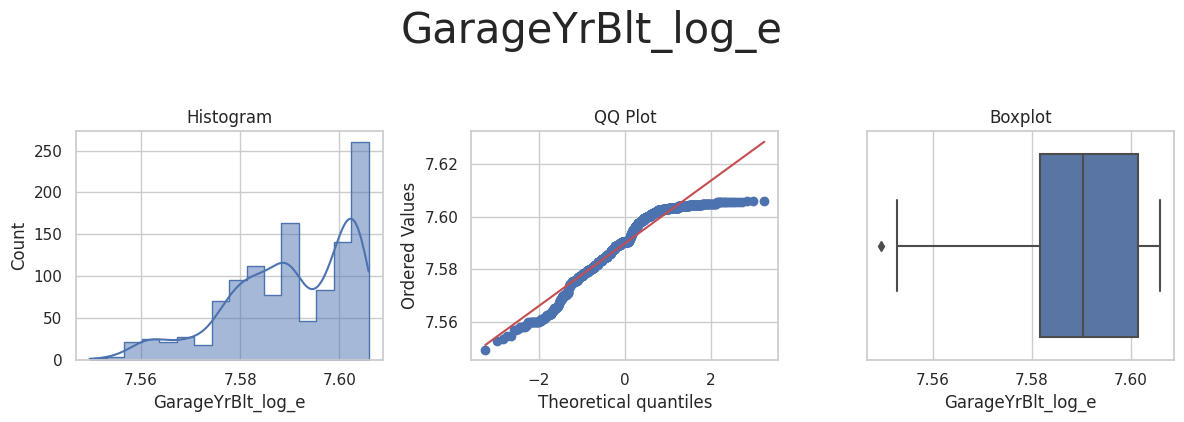

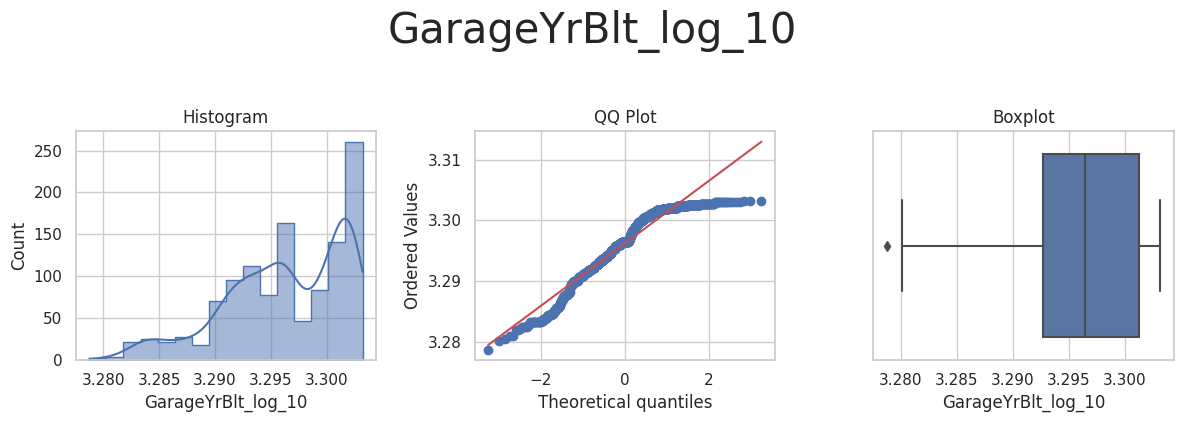

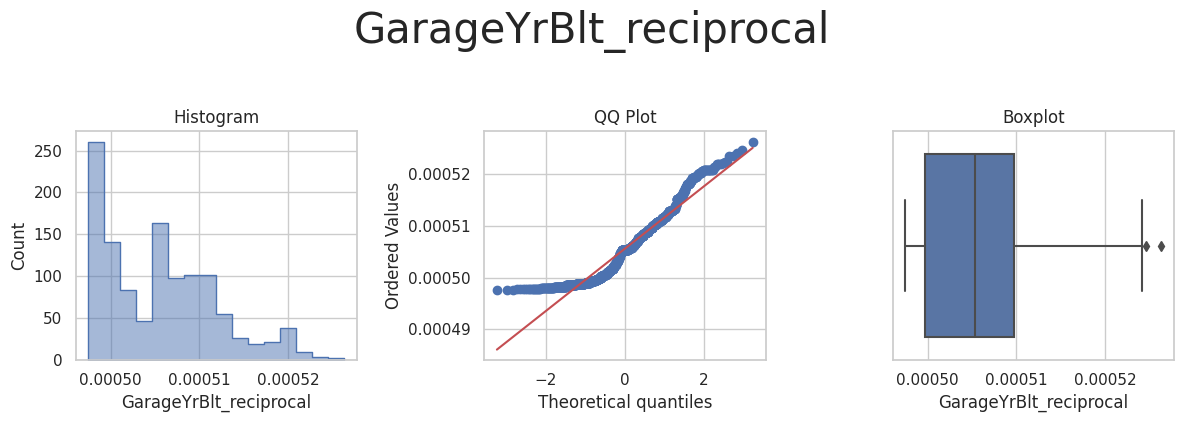

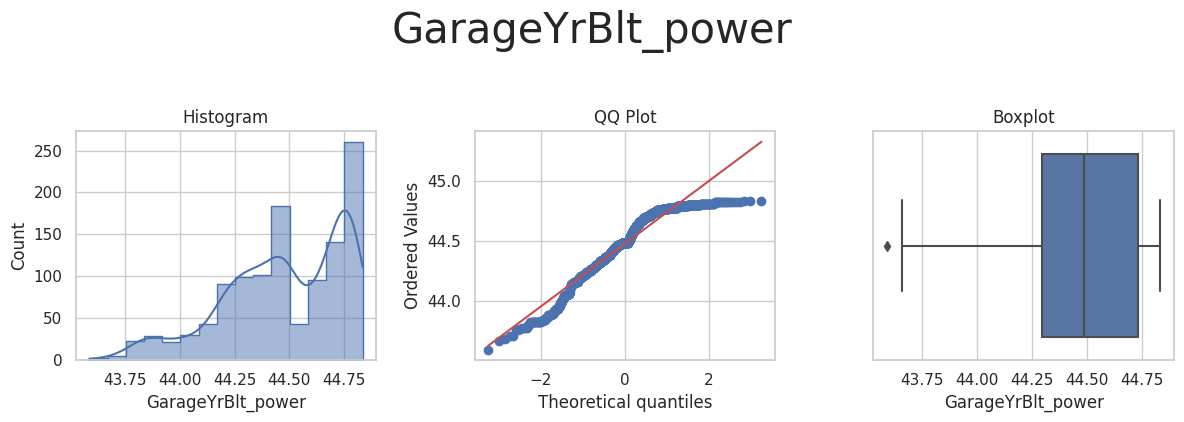

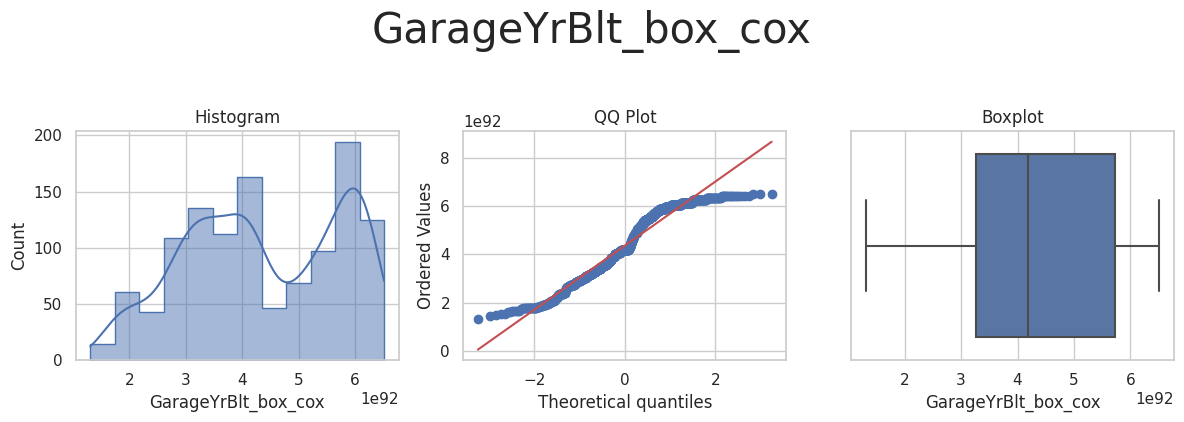

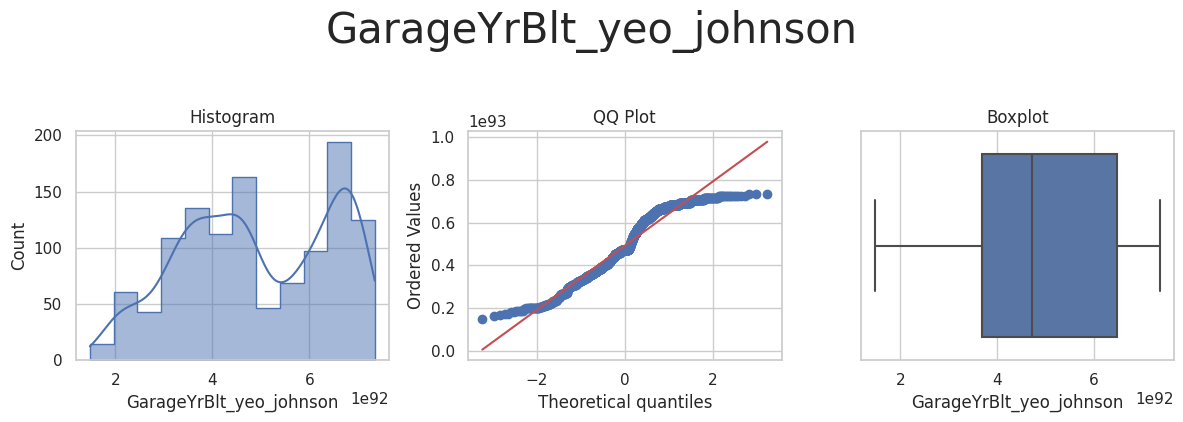



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



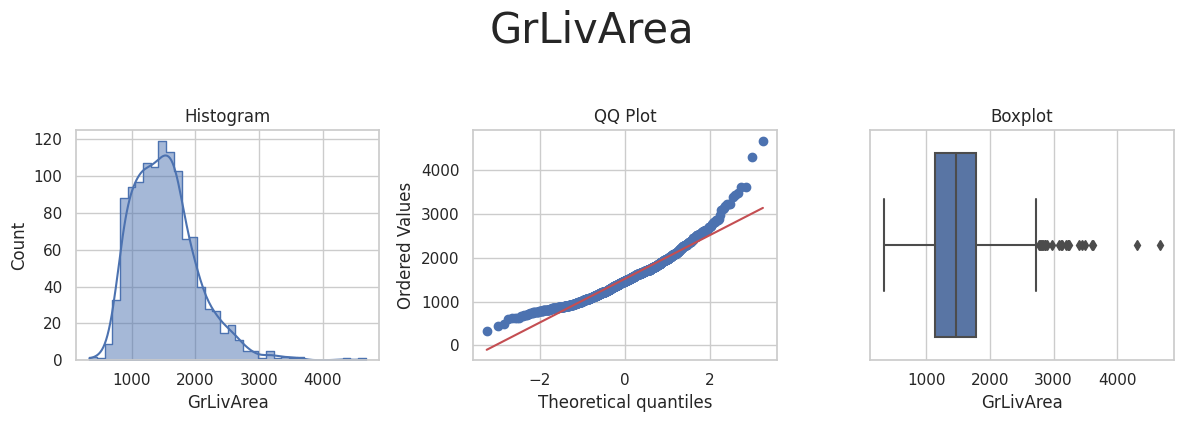

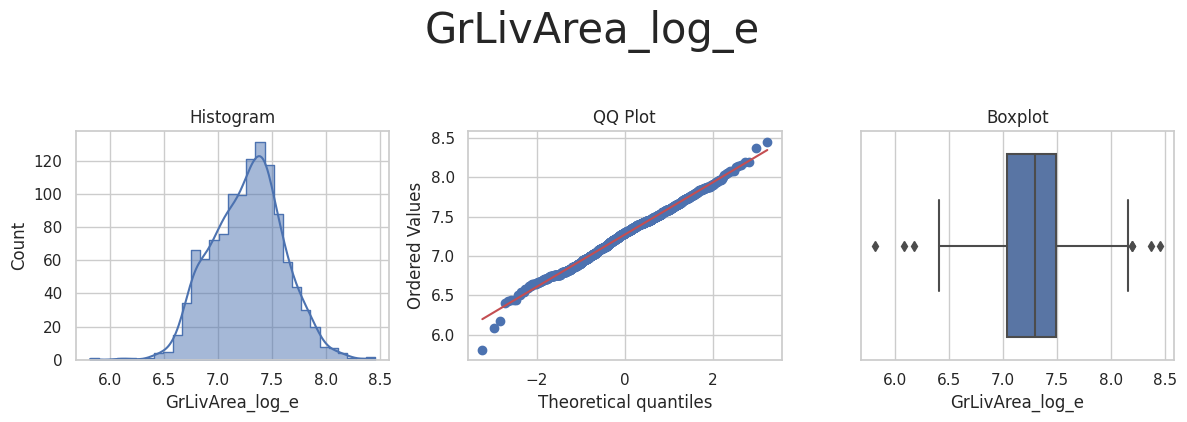

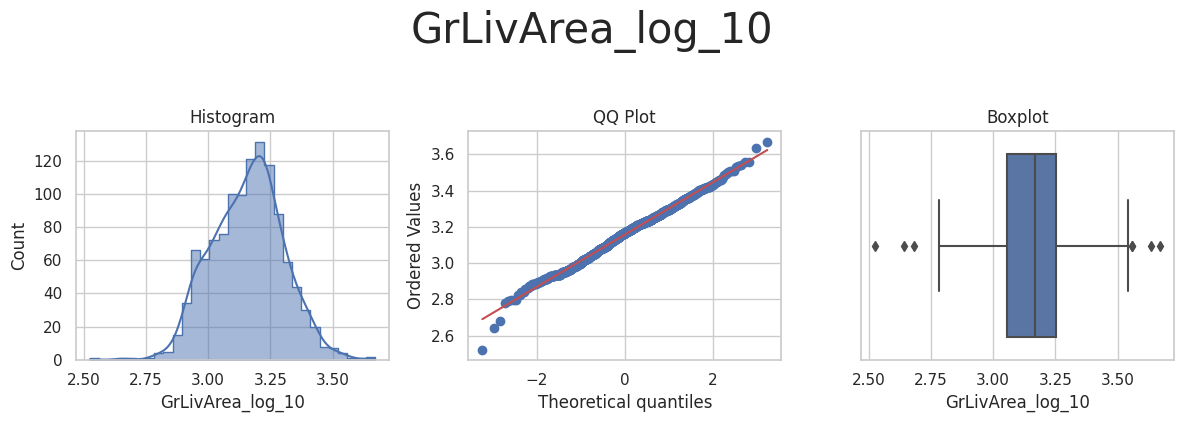

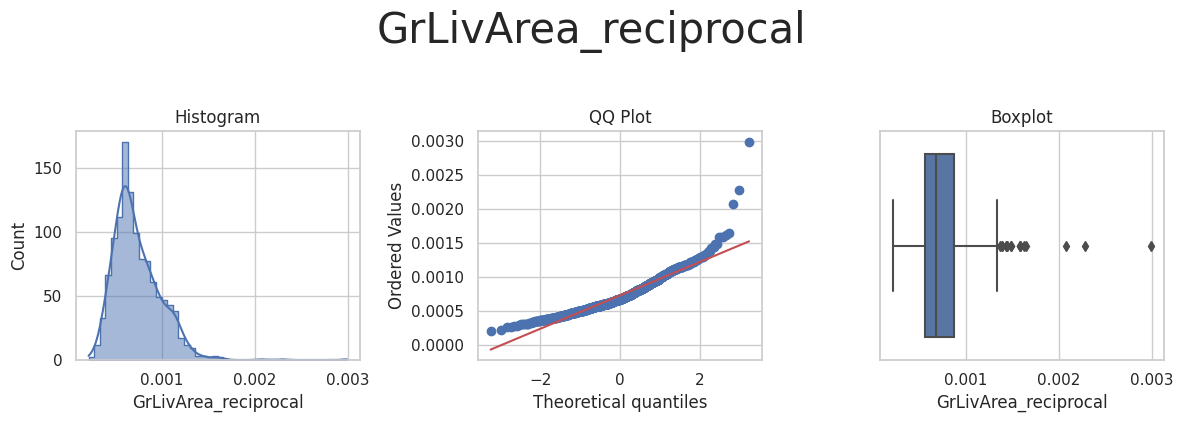

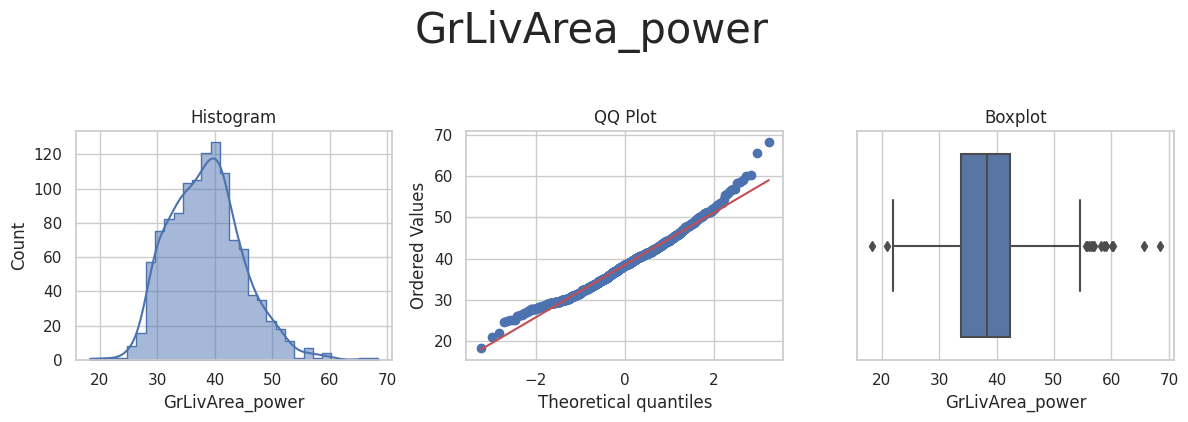

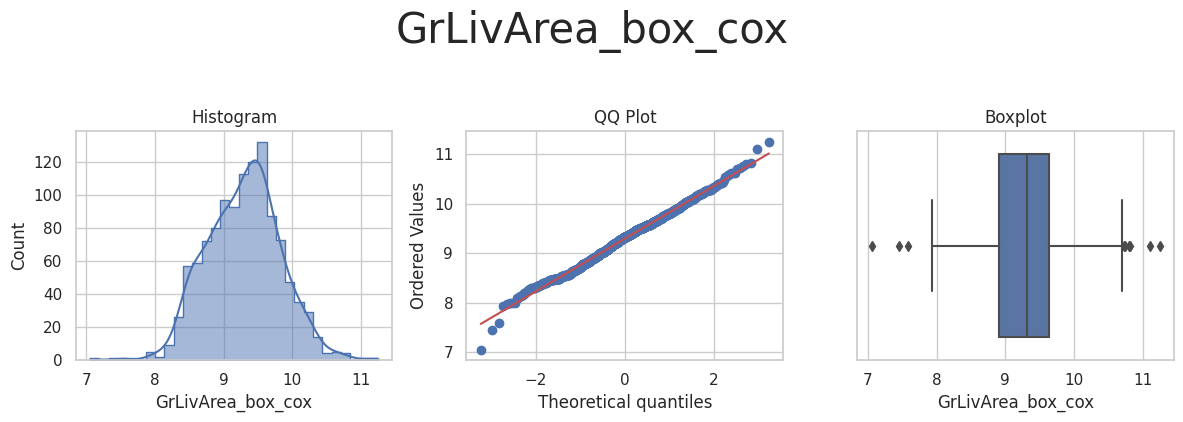

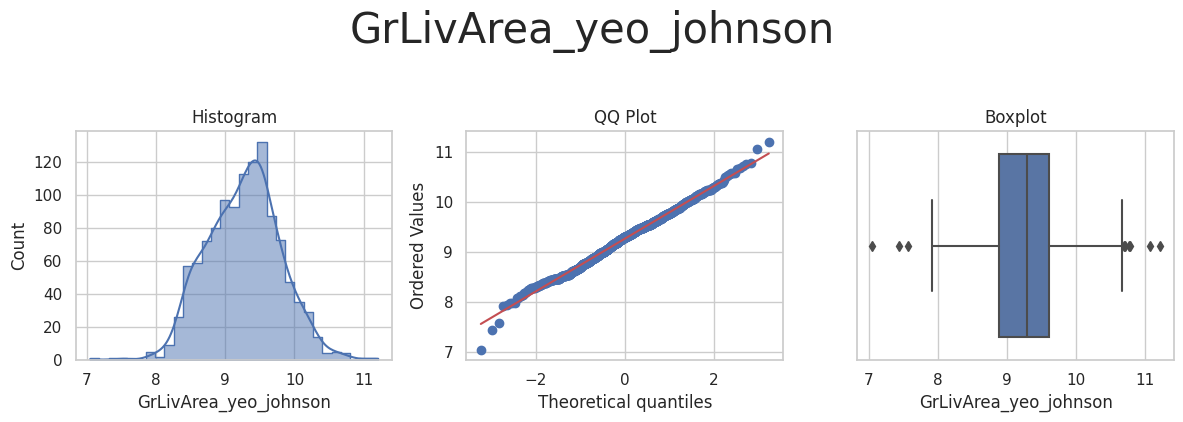



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



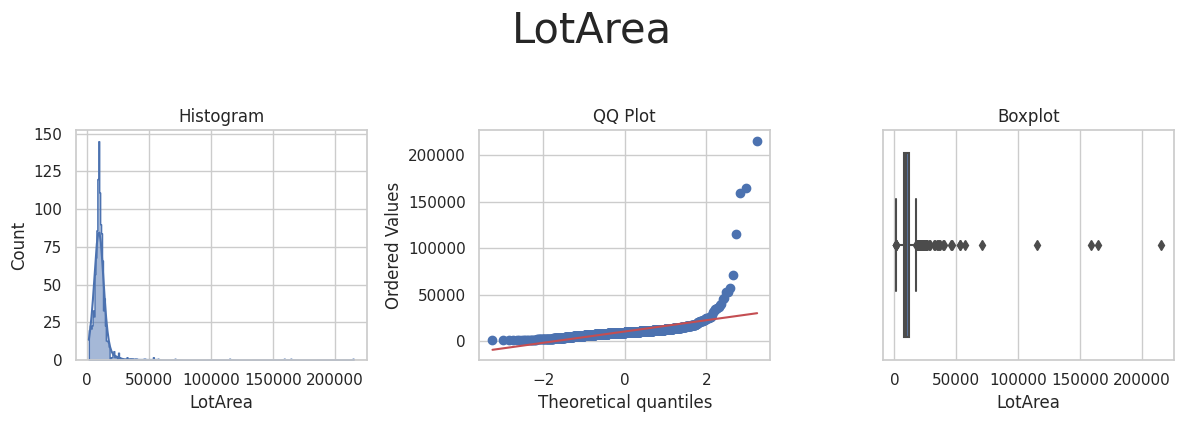

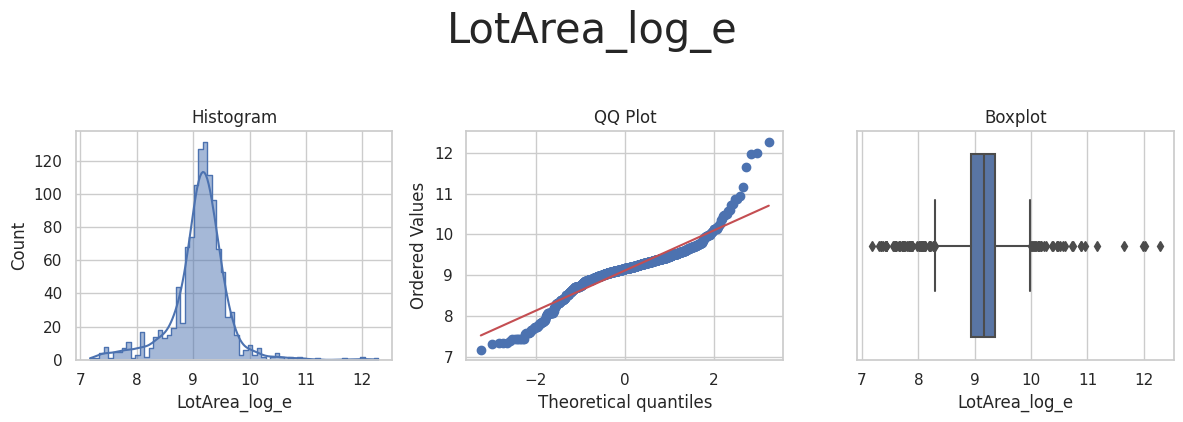

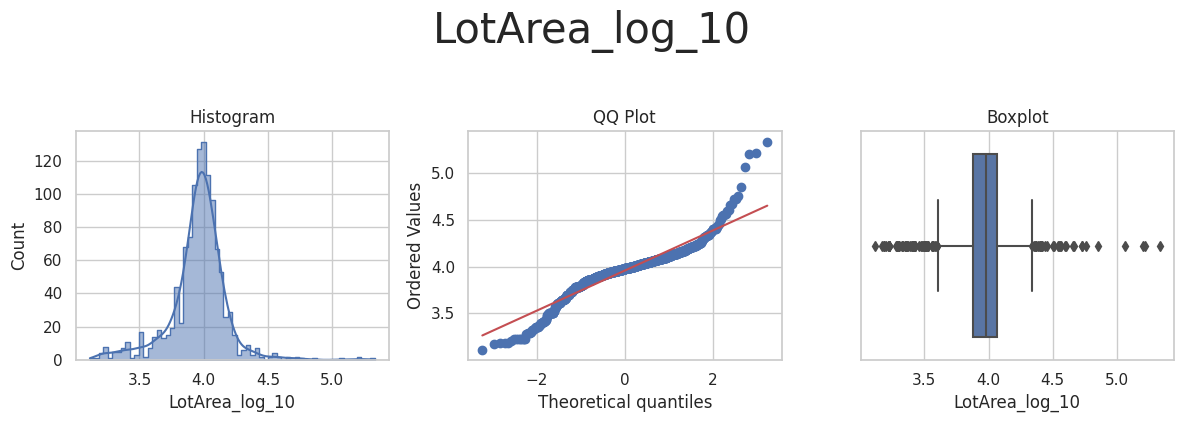

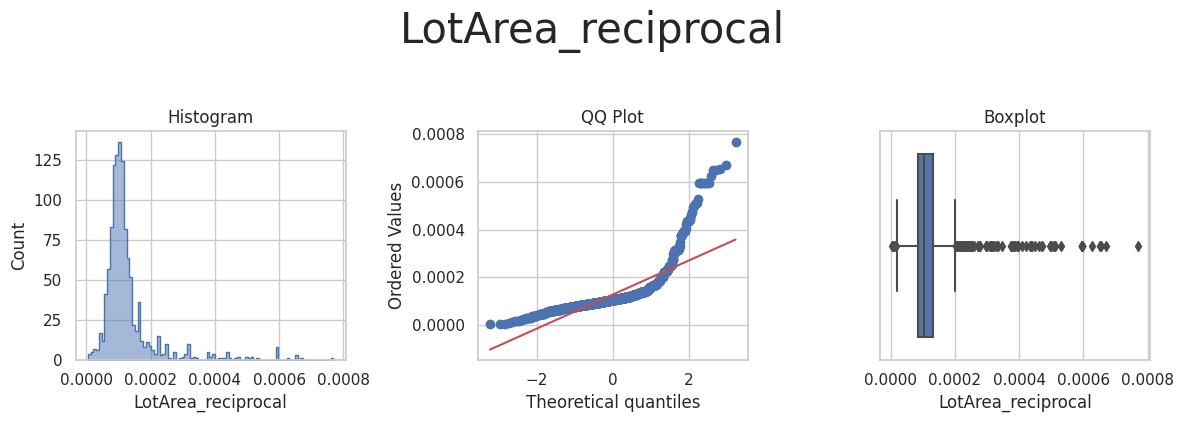

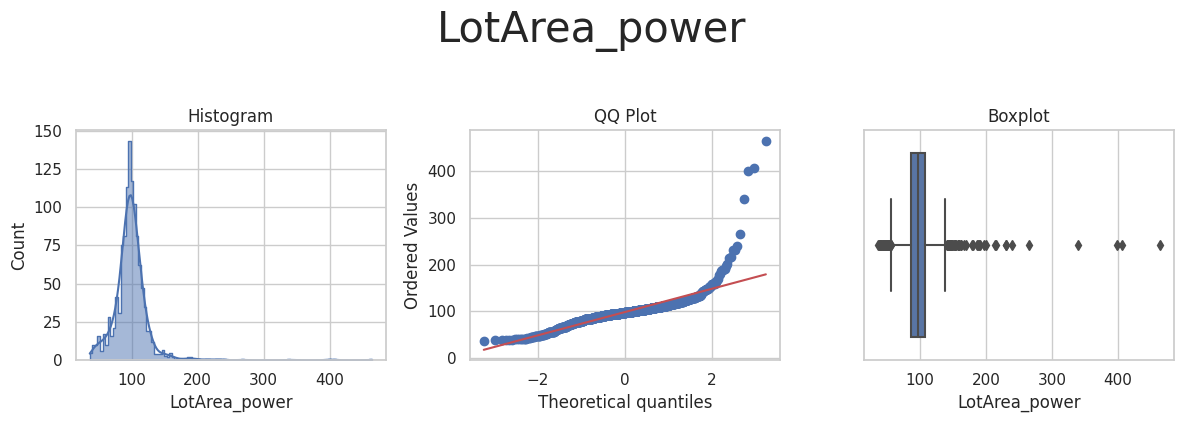

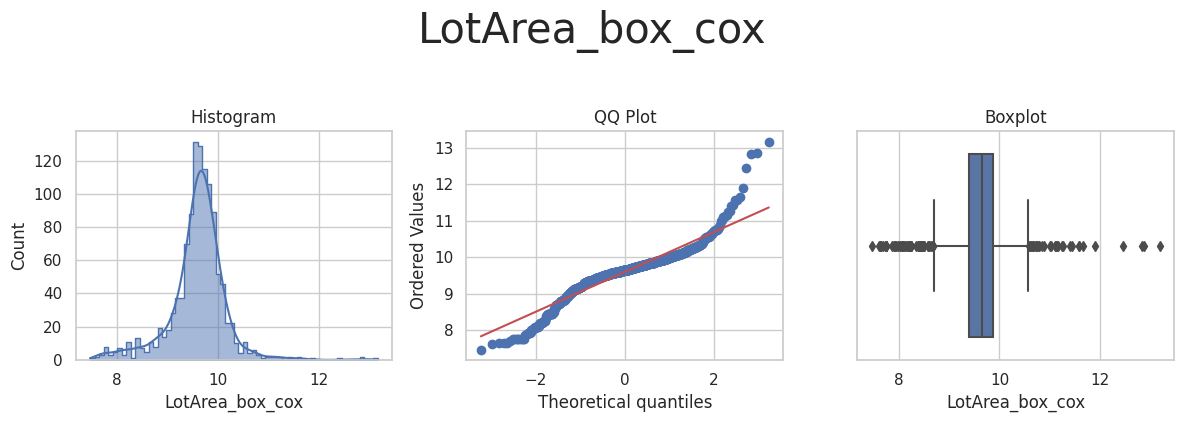

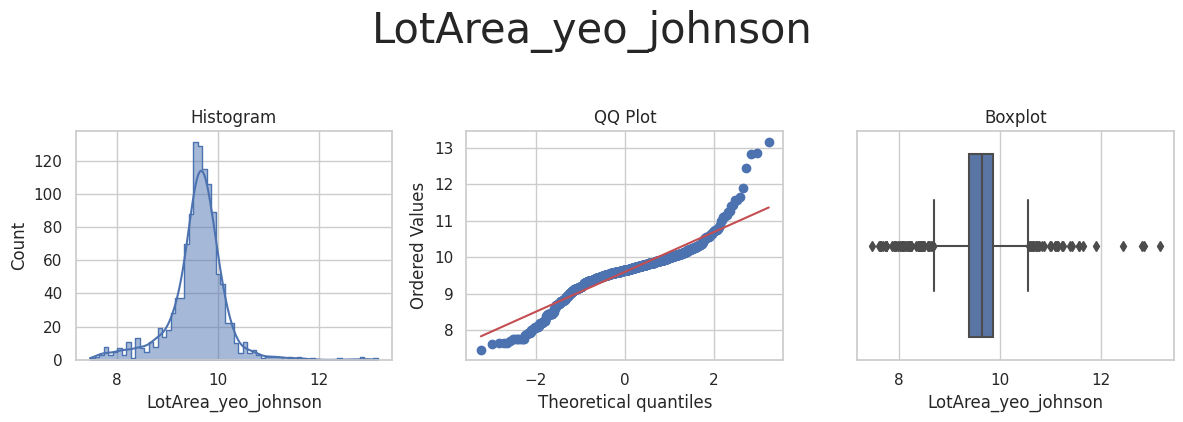



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



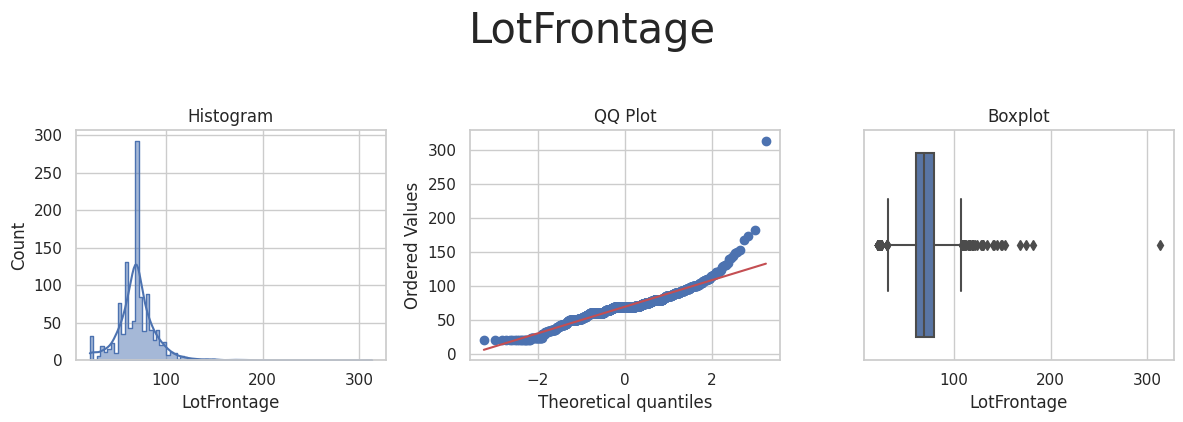

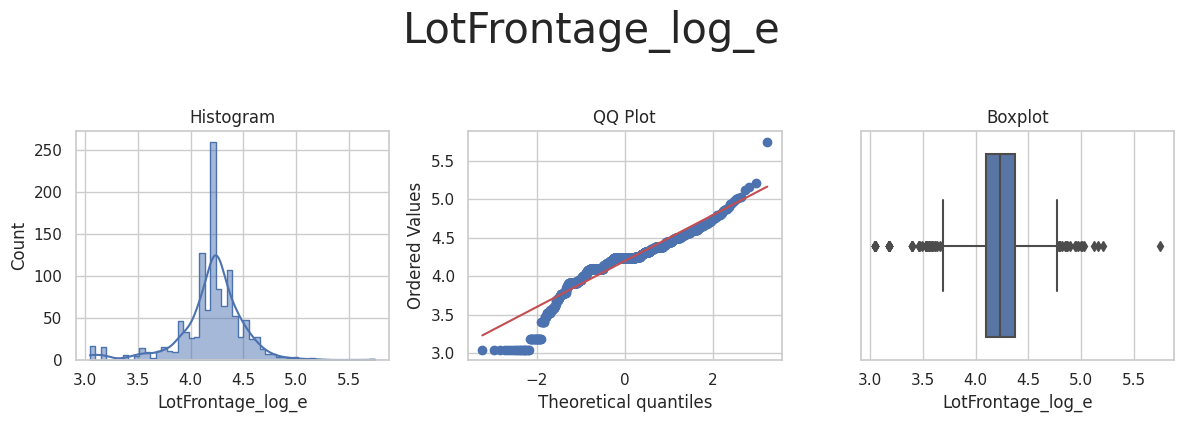

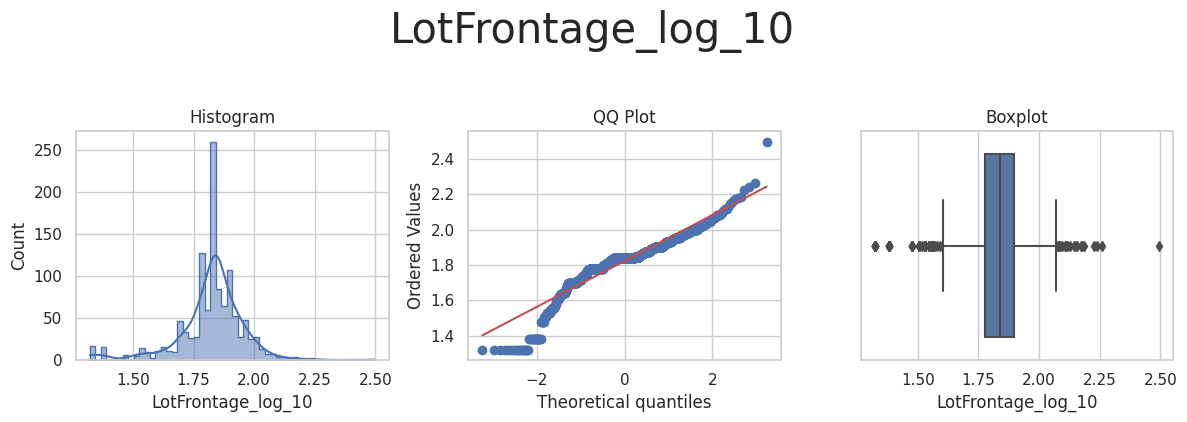

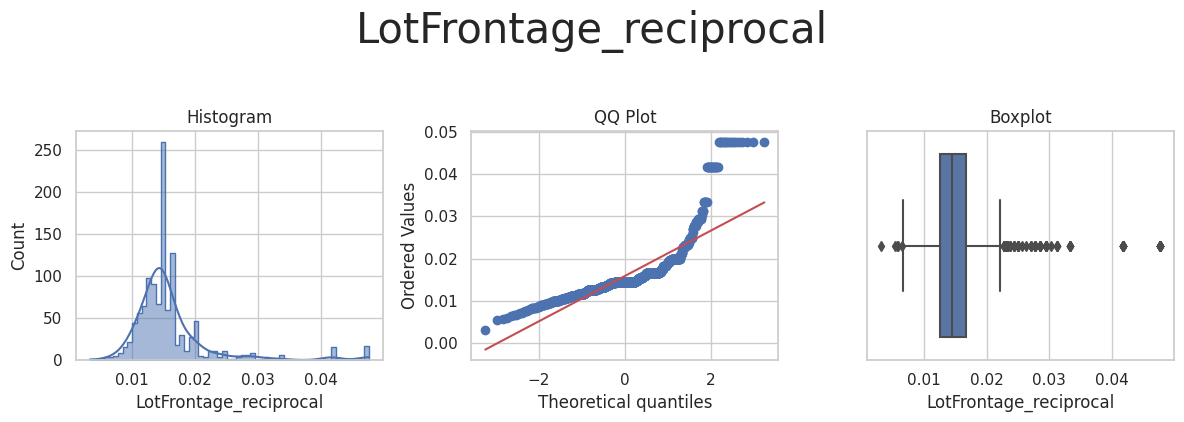

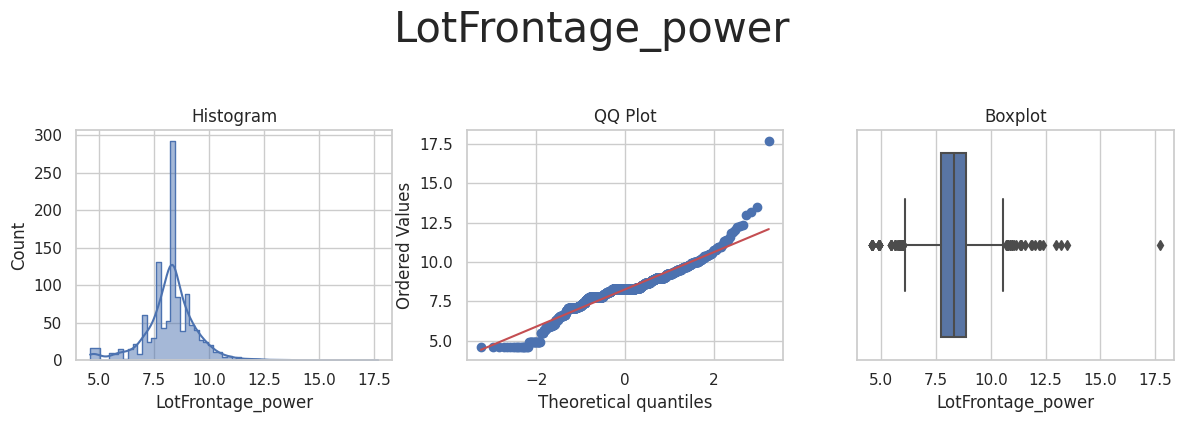

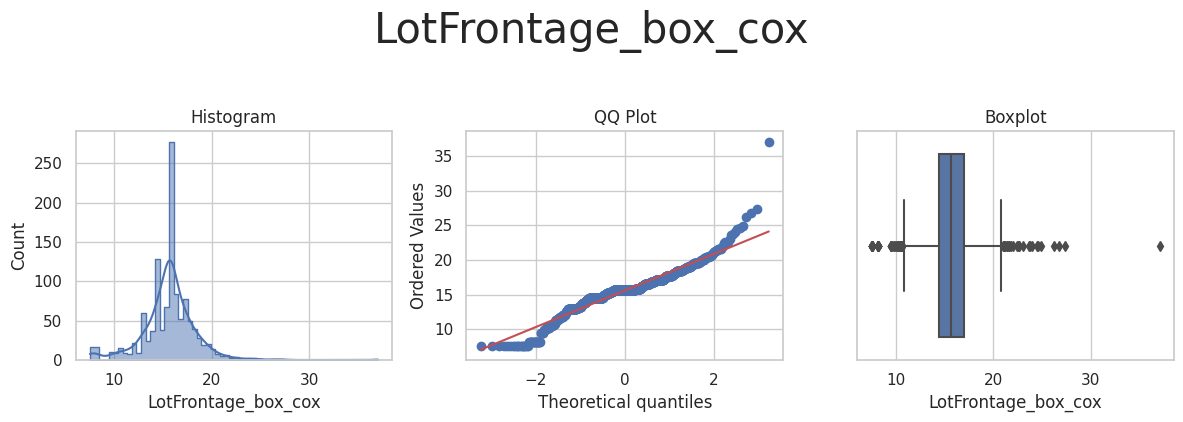

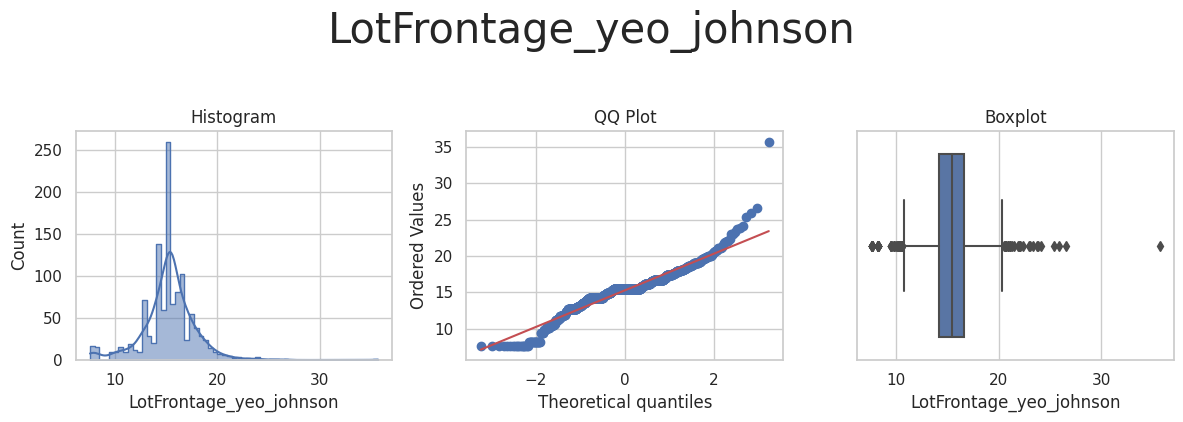



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



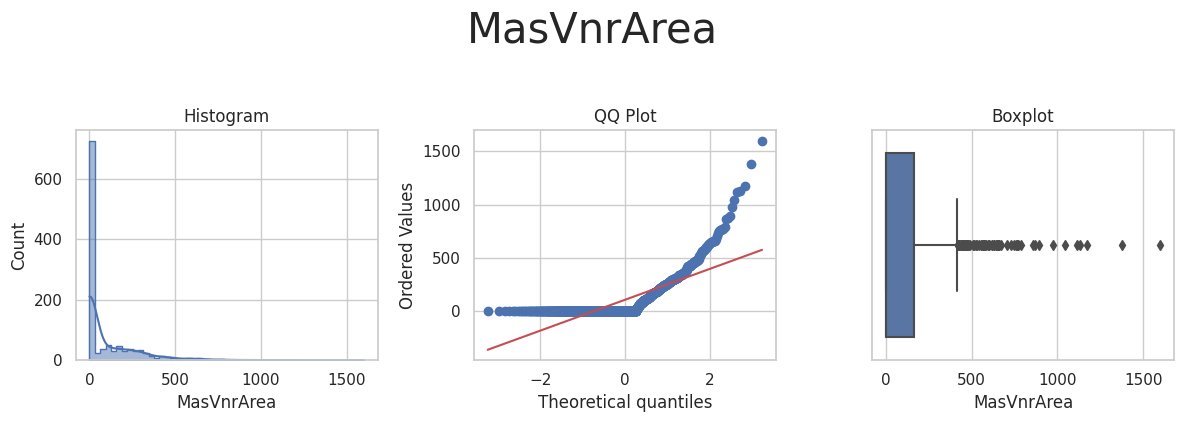

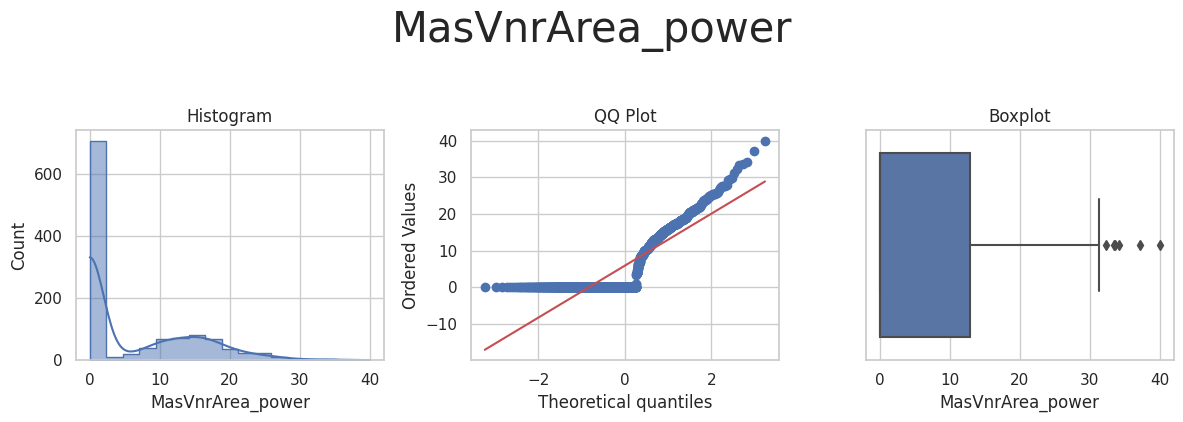

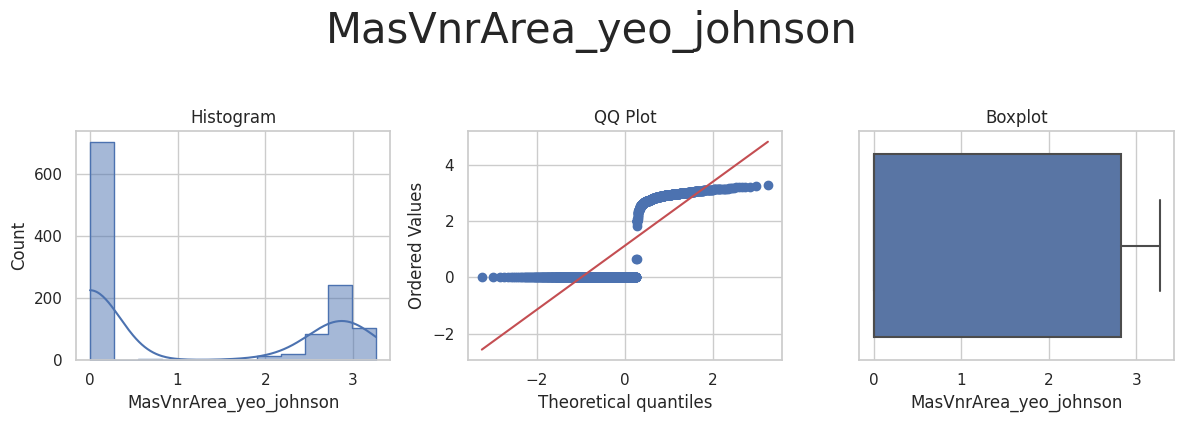



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



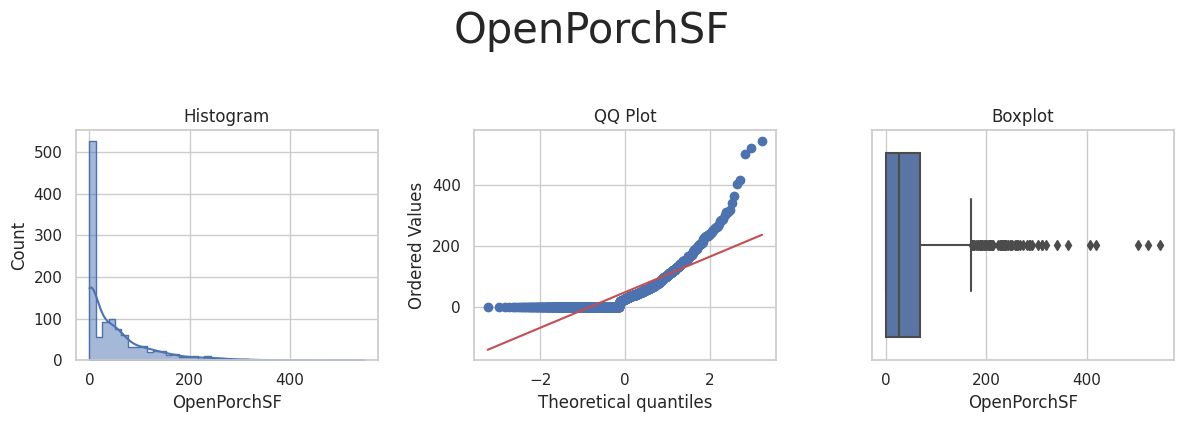

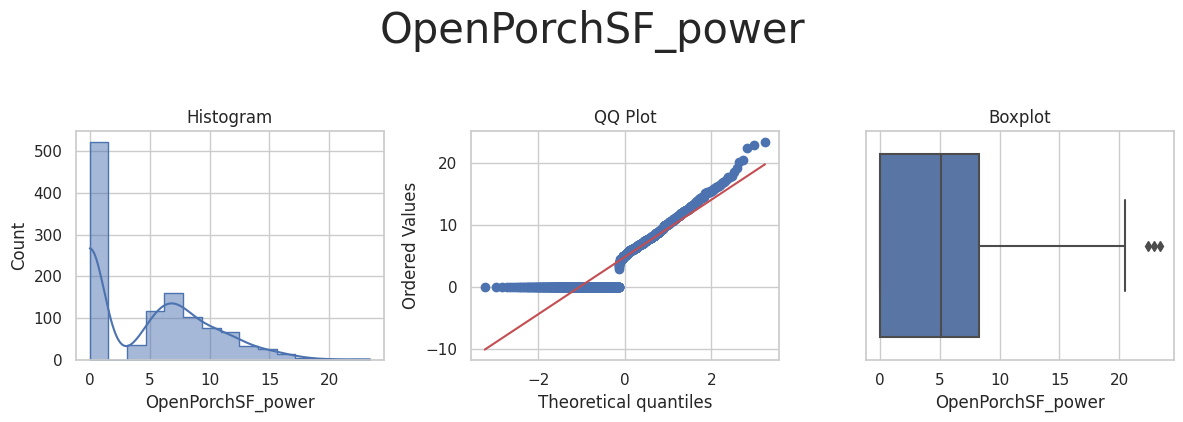

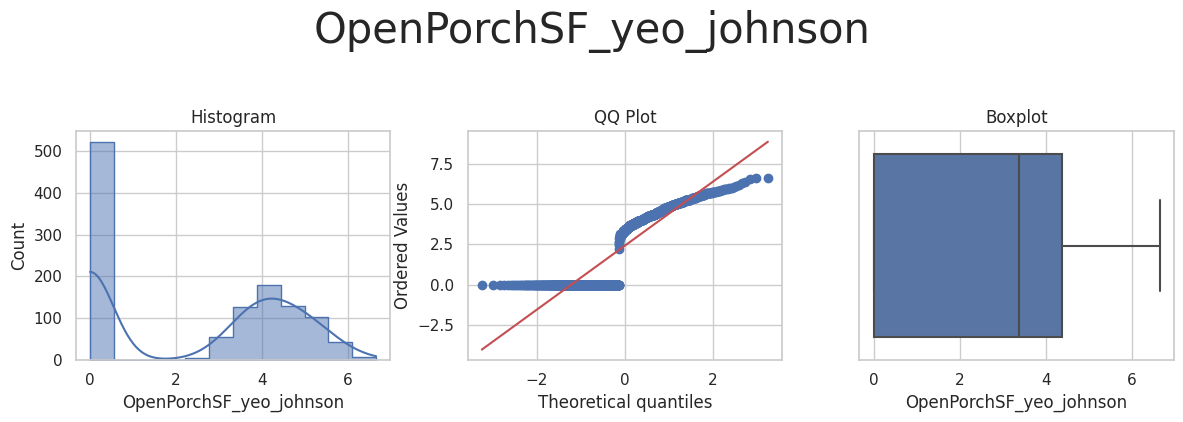

In [14]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

Interpretation: 

We want to check each plots and see if we can select a Numerical transformation method which improves the distribution. We have to check:, 
* if a histogram has bell-shaped with only one peak and is symmetric, the distribution is normal.
* if a QQ plot roughly a straight line , the distribution is normal.
* if a box plot has equal proportions around the median, the distribution is normal. 

With this in mind we can note we can apply the following: 
* `log_e` to '1stFlrSF', 'GrLivArea' and 'LotFrontage'.
* `yeo_johnson` to 'TotalBsmtSF'.
* `box_cox` to 'LotArea'.
* `power` to 'GarageArea' and 'MasVnrArea'.
* For some variables, the transformmation didn't have a positive impact and we have a nonsymetrical distribution. So we won't applly transformation to the following: '2ndFlrSF', 'GarageYrBlt' and 'OpenPorchSF'.

4. Finally, we apply the selected transformation to the Train and Test set:

In [15]:
log_transformer_vars = ['1stFlrSF', 'GrLivArea', 'LotFrontage']
yeo_transformer_vars = ['TotalBsmtSF']
box_cox_transformer_vars = ['LotArea']
power_transformer_vars = ['GarageArea', 'MasVnrArea']

In [16]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("Log_Transform",vt.LogTransformer(variables=log_transformer_vars)),
    ("YeoJohnson_Transform",vt.YeoJohnsonTransformer(variables=yeo_transformer_vars)),
    ("BoxCox_Transform",vt.BoxCoxTransformer(variables=box_cox_transformer_vars)),
    ("Power_Transform",vt.PowerTransformer(variables=power_transformer_vars)),
    ])
TrainSet = pipeline.fit_transform(TrainSet)
TestSet = pipeline.transform(TestSet)

print("* Numerical transformations done!")

* Numerical transformations done!


## Handle outliers -  Winsorization

Thanks to all the plot we were able to realized that we have outliers in most of the variables. The goal is to limit extreme values in the statistical data to reduce the effect of the outliers. We will use Winsorisation to limit the influence of outliers.

1. First, we select the variables:

In [17]:
variables_engineering = ['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF']
variables_engineering

['1stFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'GrLivArea',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF']

2. Second, we create a separate DataFrame, with the variables:

In [18]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

1stFlrSF  TotalBsmtSF  GarageArea  GrLivArea    LotArea  LotFrontage  \
0  7.510978   495.850351   27.820855   7.510978   9.880633     4.499810   
1  6.795706   280.785318   17.549929   6.795706   9.246798     4.094345   
2  6.871091   276.257124   20.784610   6.871091  10.028808     4.382027   

   MasVnrArea  OpenPorchSF  
0   21.260292          108  
1    0.000000            0  
2    0.000000            0

3. Then, we apply the transformation to handle outliers by using **winsorization** to adjust the extreme values to minimize their impact on statistical analysis or modeling:

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_iqr'] 



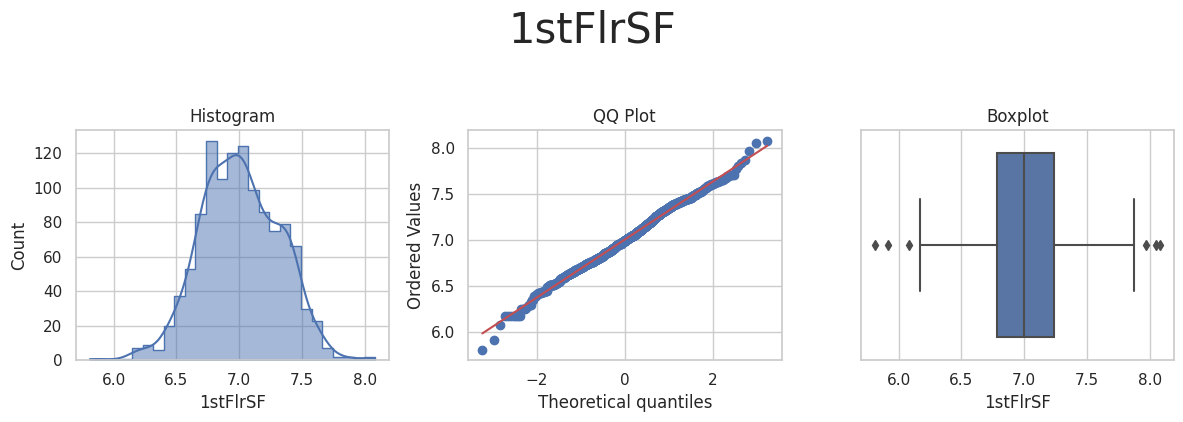

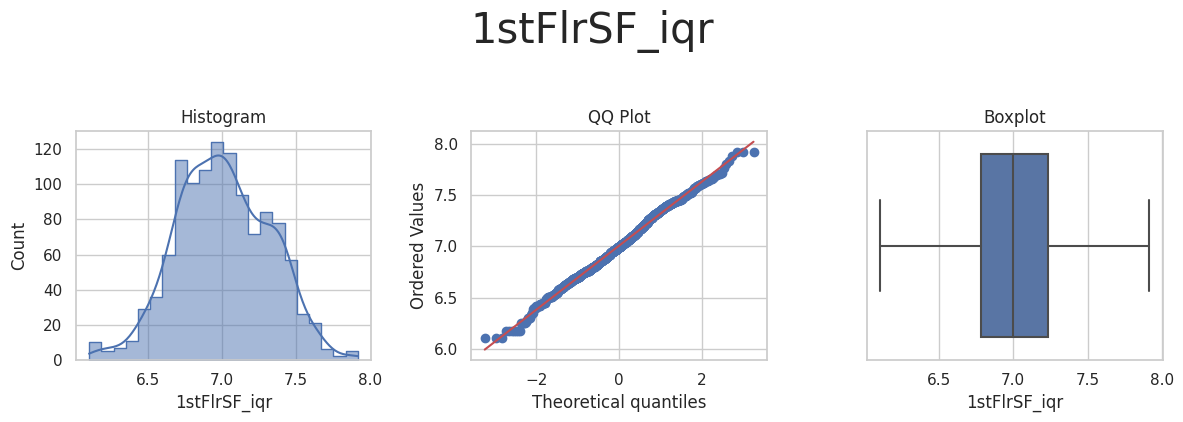



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_iqr'] 



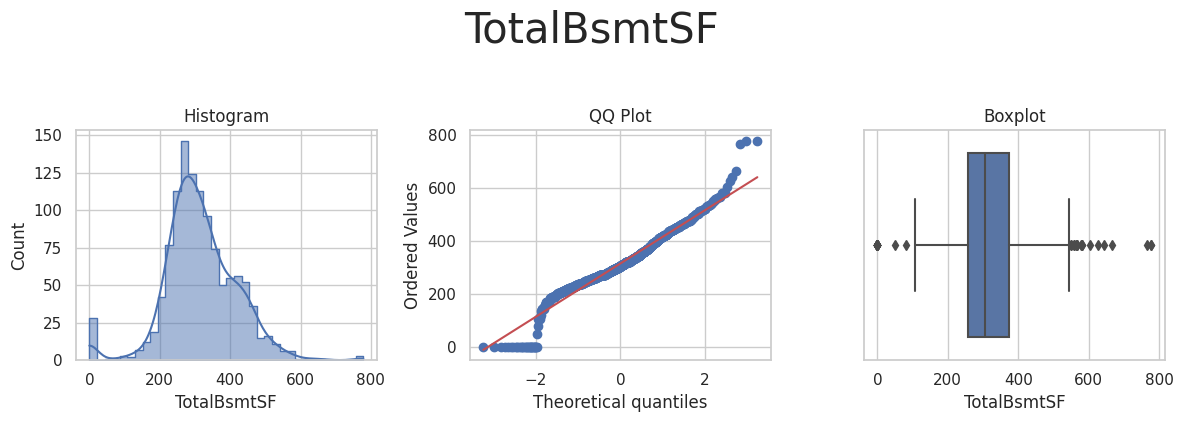

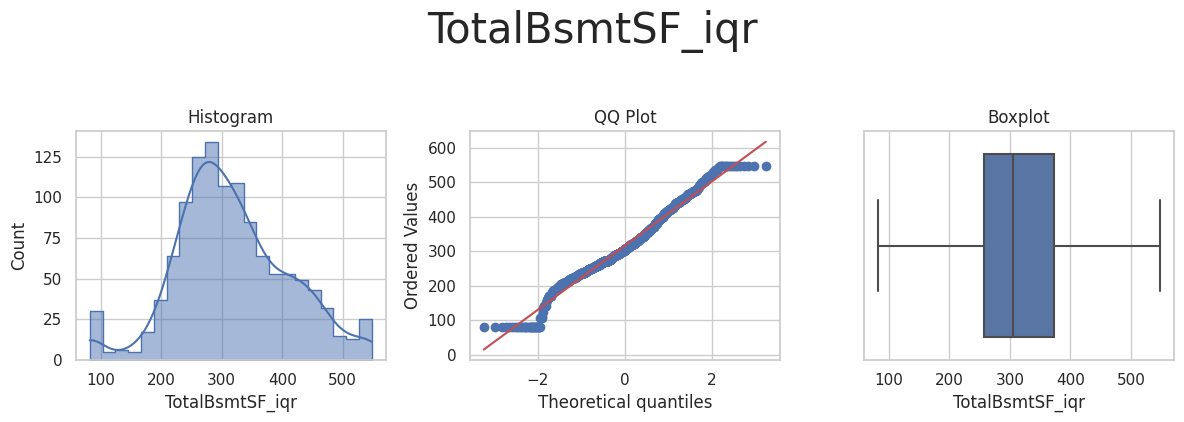



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_iqr'] 



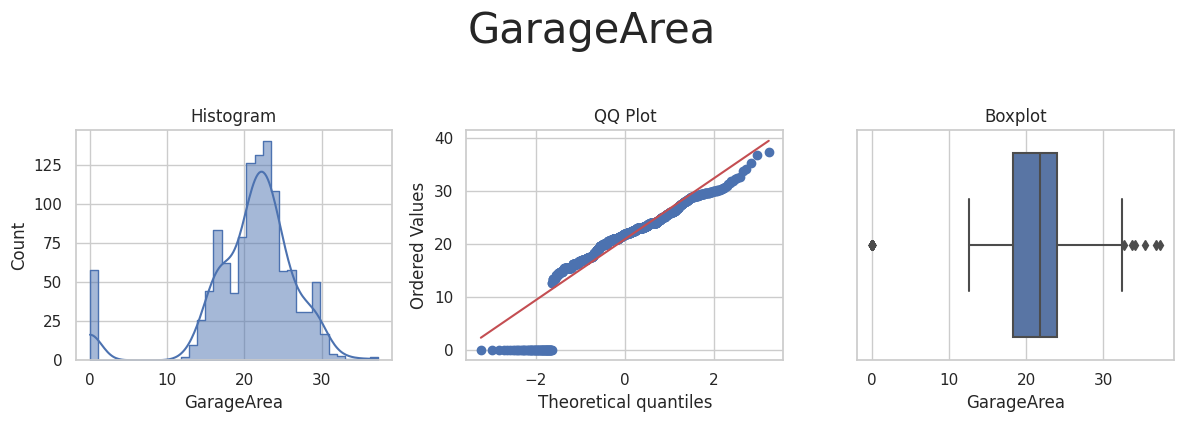

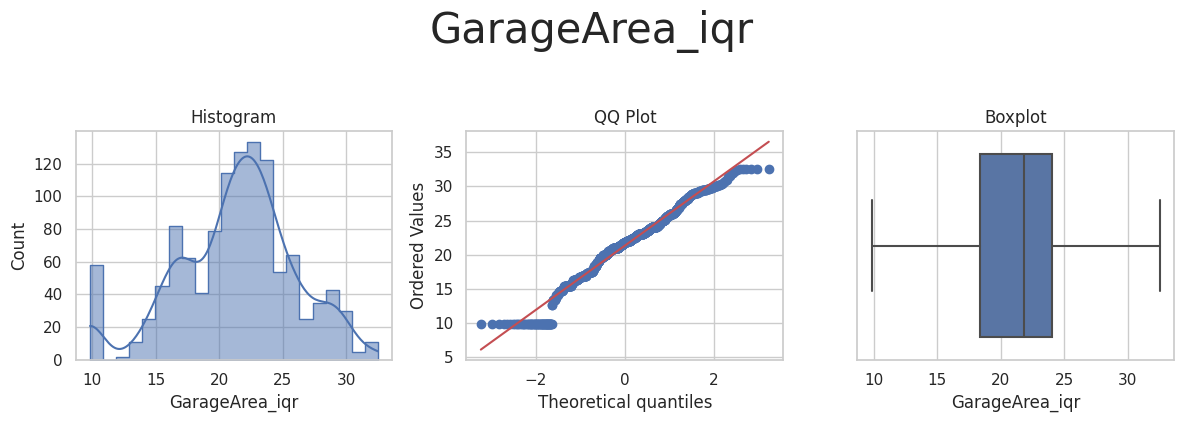



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_iqr'] 



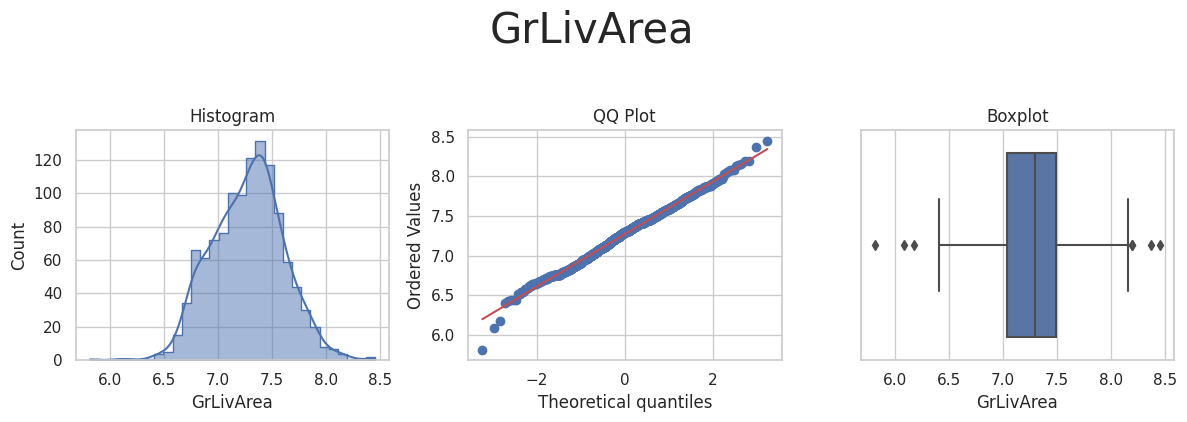

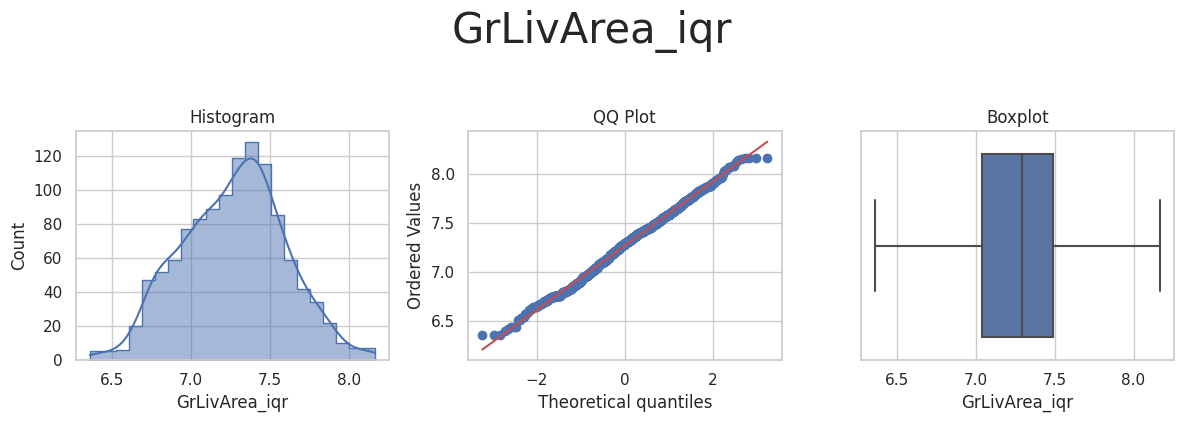



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_iqr'] 



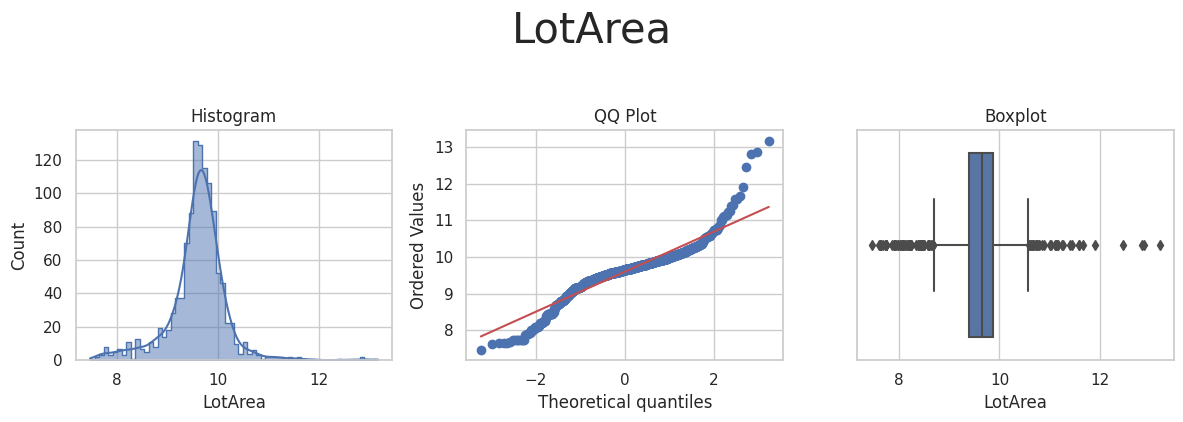

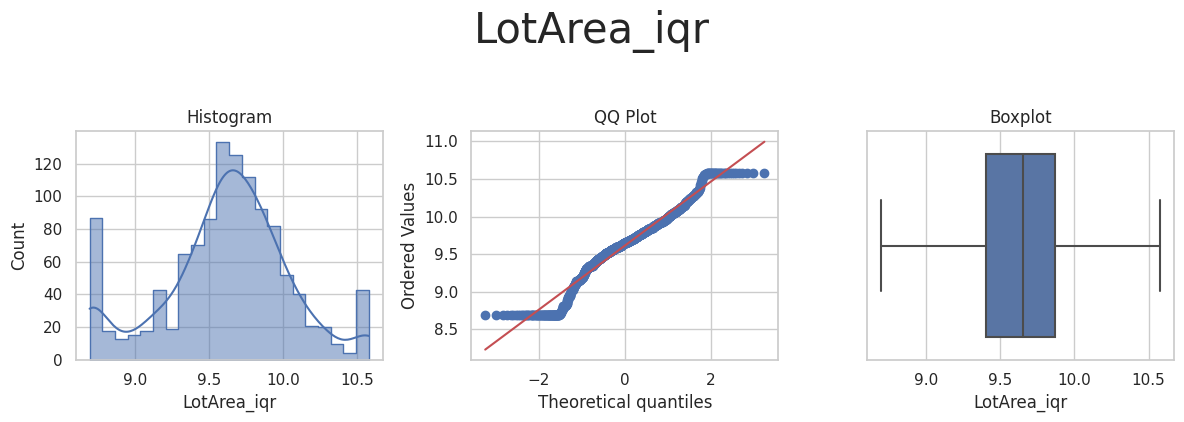



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_iqr'] 



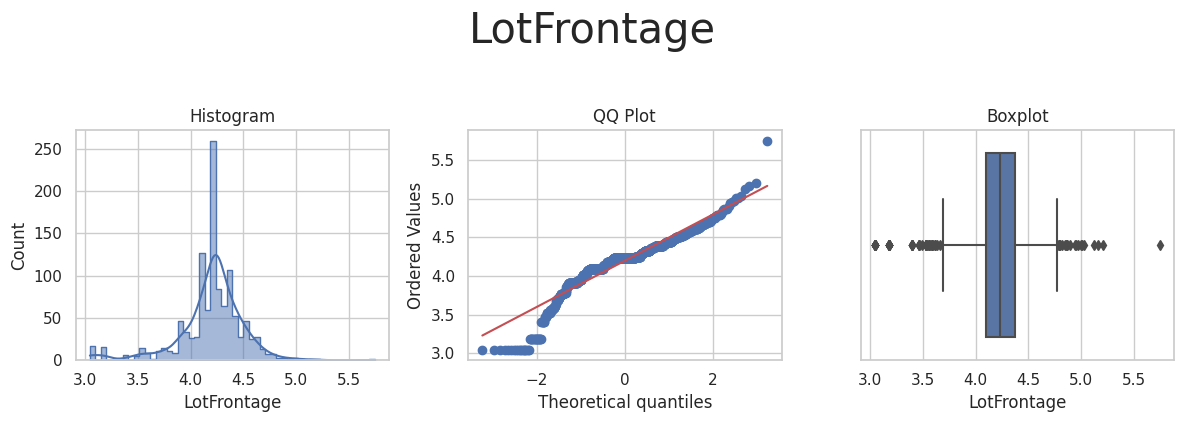

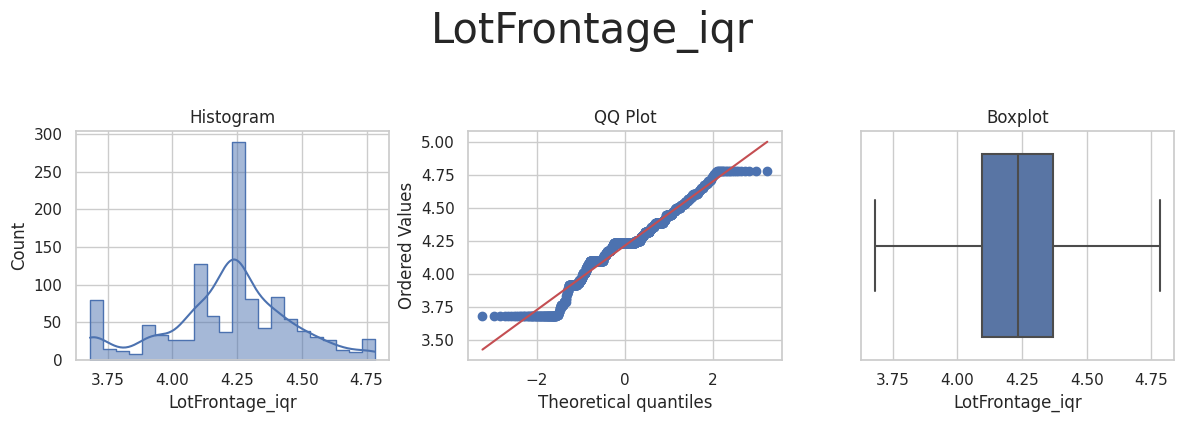



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_iqr'] 



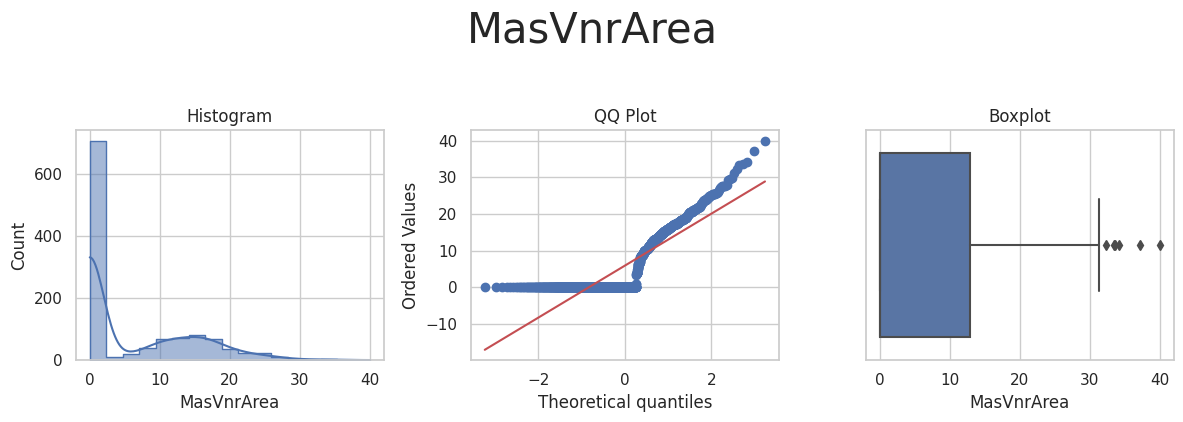

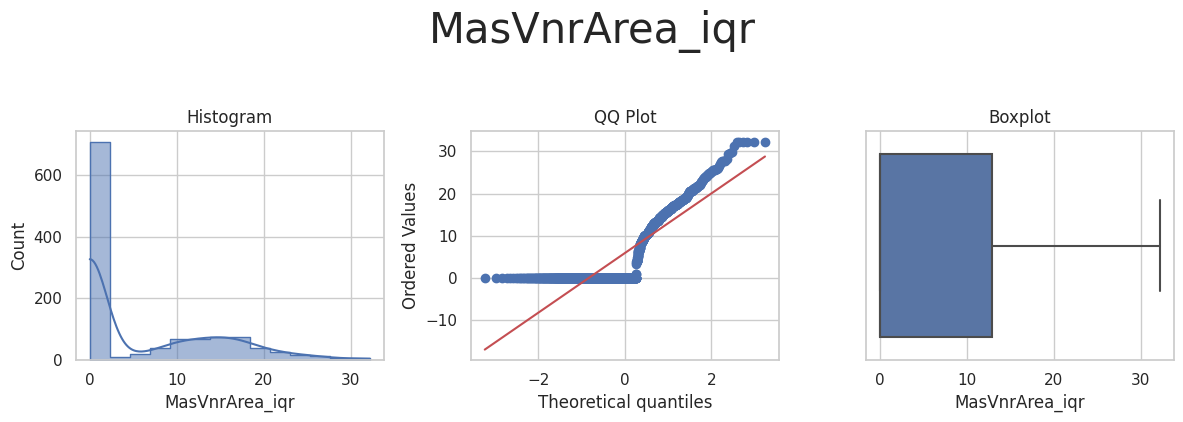



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_iqr'] 



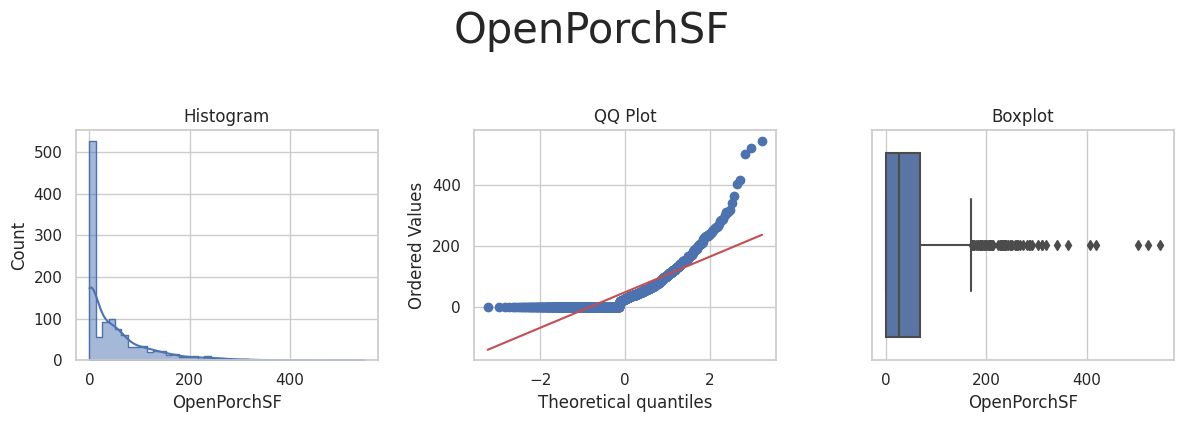

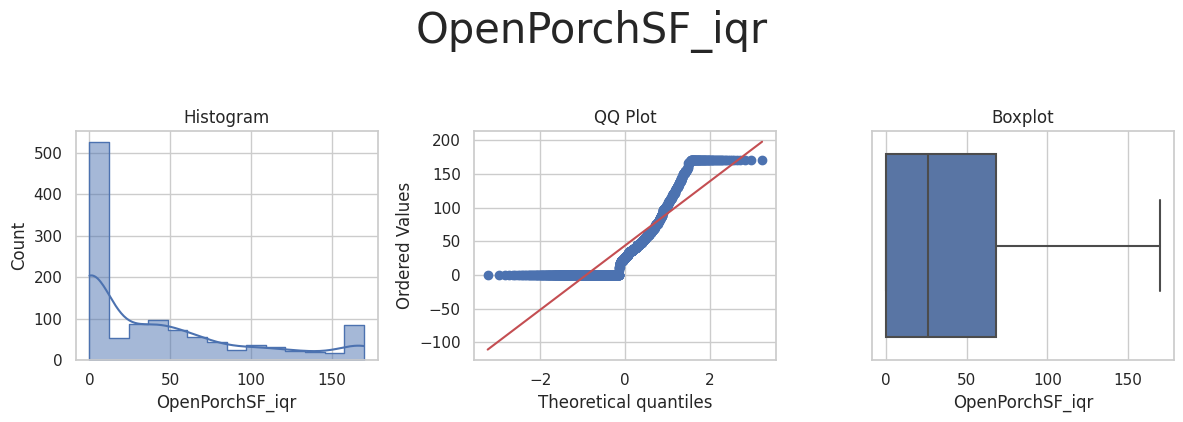

In [19]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='outlier_winsorizer')

Interpretation: 

* We know that the IQR shows where your data is most frequent.
* Overall, we can see that all outliers were removed and the distribution imporved so we will consider to apply `Winsorizer` to the variables.
* However, we can avoid using this transformer for 'LotArea' and 'LotFrontage' as their histogram bell-shaped and their QQ plot straight line have been negatively impacted.

4. Finally, we apply `Winsorizer` to the Train and Test set:

The upper and lower boundaries where the data is not an outlier are Q3 + 1.5 x IQR and Q1 - 1.5 x IQR.


In [20]:
winsoriser = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables = ['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'MasVnrArea', 'OpenPorchSF'])
TrainSet = winsoriser.fit_transform(TrainSet)
TestSet = winsoriser.fit_transform(TestSet)

print("* Outlier winsoriser transformation done!")

* Outlier winsoriser transformation done!


## SmartCorrelatedSelection Variables

With this transformer, we are going to determine which features to retain and which ones to eliminate. It works only with numerical variables but we already transformed all categorical variables.

We won't need to select variables as we will apply this transformer to all the variables.

1. So we start by creating a separate DataFrame, with the variables:

In [21]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  7.510978       0.0           3.0             0          48             0   
1  6.795706       0.0           2.0             1           0             1   
2  6.871091       0.0           2.0             1         713             2   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...    LotArea  \
0       1774   27.820855             0       2007.0  ...   9.880633   
1        894   17.549929             1       1962.0  ...   9.246798   
2        163   20.784610             0       1921.0  ...  10.028808   

   LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0     4.499810   21.260292        108.0            5            9   
1     4.094345    0.000000          0.0            5            5   
2     4.382027    0.000000          0.0            7            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0   495.850351       2007          2007     314813  
1   280.785318       1962          1962     109500  
2   276.257124       1921          2006     163500  

[3 rows x 22 columns]

2. Finally, we create engineered variabless by applying the transformations:

In [24]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea'},
 {'GarageArea', 'SalePrice'},
 {'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'}]

In [25]:
corr_sel.features_to_drop_

['1stFlrSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'YearRemodAdd']

---

# Conclusions and Next Steps

The list below shows the transformations needed for feature engineering.

Feature Engineering Transformers

* Ordinal categorical encoding: ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
* Numerical Transformations: Log Transformation for ['1stFlrSF', 'GrLivArea', 'LotFrontage'], Yeo-Johnson Transformation for ['TotalBsmtSF'], Box-Cox Transformation for ['LotArea'] and Power Transformation ['GarageArea', 'MasVnrArea'].
* Winsoriser Transformations: ['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'MasVnrArea', 'OpenPorchSF']
* Smart Correlation Selection: ['1stFlrSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'YearRemodAdd']